### Hyperparameters of interest

In [1]:
extract_activations_metrics_flag = 0
perform_glimpse_group_decoding = 0
extract_scegram_results = 0
simulate_glimpses_icl = 0
perform_position_decoding = 0 # this takes long to run - 0 if don't need it, 1 if run, 2 if plot prev-run
extract_all_network_rdm_correlations = 0
extract_gpn_rdms = 0

net_abbrv = 'GPN-RS-SimCLR' # GPN/s/cGSN, B/S/R/RS, SimCLR/ILSVRC/Dinov2B, -dg3p/dg3r/random
net_id = 1 

load_epoch = -2 # -3 for last epoch, -2 for best (default), -1 for init 

dataset_path = '/Users/sushrutthorat/Library/CloudStorage/GoogleDrive-sushrut.thorat94@gmail.com/My Drive/Work/Postdoc_IKW/Projects/gaze-stitch/codes/version11/datasets/' # Folder where dataset exists (end with '/')

### Network and package loading

In [2]:
# Packages needed

from analysis_helpers.analysis_helper_funcs import get_net_params, get_hyp, get_test_515_loader, extract_activations_metrics, resize_and_center_crop, get_RN50_embeddings, load_pickle, compute_noise_ceiling, compute_gpn_correlations, compute_network_correlations, extract_GPN_RDMs, variance_partitioning_analysis, get_coco515_dg3_glimpse_cutouts_and_scene, perm_test_scegram, OnTheFlyExtractor, compute_network_correlations_all, get_test_515_loader_e2e, extract_activations_metrics_e2e, get_coco515_dg3_glimpse_cutouts_and_scene_e2e, extract_GPN_RDMs_e2e, mean_and_bootstrap_ci
from train.models.helper_funcs import get_network_model, get_network_model_e2e
PYTORCH_ENABLE_MPS_FALLBACK=1

import os, sys, glob, random, torch, h5py, pickle

import numpy as np
from numpy.linalg import norm
from scipy.stats import ttest_1samp, ttest_ind, ttest_rel, wilcoxon
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family']        = 'sans-serif'
mpl.rcParams['font.sans-serif']    = ['Arial', 'Helvetica Neue', 'DejaVu Sans']
plt.style.use('seaborn-v0_8-colorblind')
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D
from PIL import Image

# If 'figures'/'saved_actvs'/'rdms' directories doesn't exist, they will be created to save plots and data
figures_dir = 'figures/'
saved_actvs_dir = 'saved_actvs/'
rdms_dir = 'rdms/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
if not os.path.exists(saved_actvs_dir):
    os.makedirs(saved_actvs_dir)
if not os.path.exists(rdms_dir):
    os.makedirs(rdms_dir)

In [3]:
# Package hyperparameters for the model

recurrence, provide_loc, bbv, n_rnn, timestep_multiplier, input_dropout, rnn_dropout, gaze_type, dva_dataset = get_net_params(net_abbrv)
img_size = 256
glimpse_size = 91 if dva_dataset == 'NSD' else 36 
input_dim = 2048 if bbv != 5 else 768
input_dim = 512 if 'e2e' in net_abbrv else input_dim
hyp = get_hyp(dataset_path, gaze_type, dva_dataset, n_rnn, timestep_multiplier, rnn_dropout, input_dropout, net_id, load_epoch, recurrence, provide_loc, bbv, net_abbrv)

# Loading the network

print('Loading network...')
net, net_name = get_network_model(hyp) if 'e2e' not in net_abbrv else get_network_model_e2e(hyp)
if load_epoch == -2:
    net_save_path = f'train/logs/net_params/{net_name}/{net_name}.pth'
elif load_epoch == -3:
    net_save_path = f'train/logs/net_params/{net_name}/{net_name}_final.pth'
else:
    net_save_path = f'train/logs/net_params/{net_name}/{net_name}_epoch_{load_epoch}.pth'
net.load_state_dict(torch.load(net_save_path,map_location=torch.device('cpu')))
net.to(hyp['optimizer']['device'])
net.eval()
print(f'Network is ready! Loaded from:\n{net_save_path}')

net_name_og = net_name # required for loss data grabbing
net_name = net_name + f'_epoch_{load_epoch}' if load_epoch != -2 else net_name

Getting hyperparameters for GPN-RS-SimCLR
Loading network...

Using bbv-6 features

Network name: gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1

The network has 27299839 trainable parameters

Network is ready! Loaded from:
train/logs/net_params/gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1/gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1.pth


### Network performance

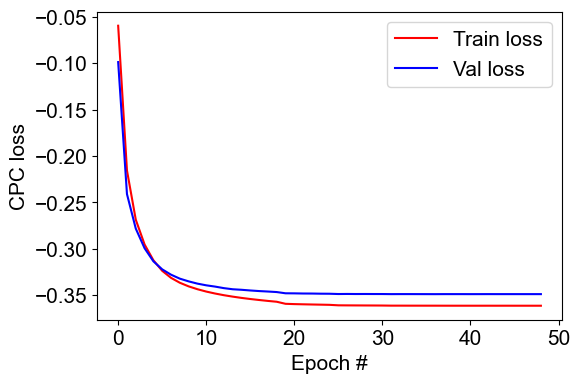

In [4]:
perf_data = np.load(f'train/logs/perf_logs/{net_name_og}/loss_{net_name_og}.npz')
xt = perf_data['train_loss'].shape[0]

plt.figure(figsize=(6,4))   
plt.plot(np.arange(xt),perf_data['train_loss'],'r-')
plt.plot(np.arange(xt),perf_data['val_loss'],'b-')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Epoch #',fontsize=15)
plt.ylabel('CPC loss',fontsize=15)
plt.legend(['Train loss','Val loss'],fontsize=15);

In [5]:
best_epoch_loss = np.where(perf_data['val_loss'] == perf_data['val_loss'].min())[0].max()+1
print(f'Best epoch based on val loss: {best_epoch_loss} with loss = {perf_data["val_loss"].min():.4f}')

Best epoch based on val loss: 37 with loss = -0.3490


### Extracting test-515 activations and metrics

In [6]:
glimpse_loss = hyp['optimizer']['losses']['glimpse_loss']
semantic_loss = hyp['optimizer']['losses']['semantic_loss']

if extract_activations_metrics_flag:

    dataloader = get_test_515_loader(hyp,shuffler=True) if 'e2e' not in net_abbrv else get_test_515_loader_e2e(hyp,shuffler=True)

    if glimpse_loss:
        cos_sim_target, cos_sim_other_fix, cos_sim_other_sc, cos_sim_diff, cos_sim_current_fix, rank_target, lstm_reps, scene_reps, scene_multihot_reps, llm_reps, actv_reps, fix_coords_all, next_fix_rel_coords_all, img_n_all, trace_n_all, n_samples_batch, output_reps, cos_sim_target_in, cos_sim_other_fix_in, cos_sim_other_sc_in, cos_sim_diff_in, cos_sim_current_fix_in = extract_activations_metrics(dataloader, net, hyp) if 'e2e' not in net_abbrv else extract_activations_metrics_e2e(dataloader, net, hyp)
    elif semantic_loss:
        cos_sim_target, cos_sim_other_sc, cos_sim_diff, rank_target, lstm_reps, scene_reps, scene_multihot_reps, llm_reps, actv_reps, fix_coords_all, next_fix_rel_coords_all, img_n_all, trace_n_all, n_samples_batch, output_reps = extract_activations_metrics(dataloader, net, hyp) if 'e2e' not in net_abbrv else extract_activations_metrics_e2e(dataloader, net, hyp)
    else:
        bce_loss, lstm_reps, scene_reps, scene_multihot_reps, llm_reps, actv_reps, fix_coords_all, next_fix_rel_coords_all, img_n_all, trace_n_all, n_samples_batch, output_reps = extract_activations_metrics(dataloader, net, hyp) if 'e2e' not in net_abbrv else extract_activations_metrics_e2e(dataloader, net, hyp)

    # Save the results
    save_data = {
        'lstm_reps': lstm_reps,
        'scene_reps': scene_reps,
        'scene_multihot_reps': scene_multihot_reps,
        'llm_reps': llm_reps,
        'actv_reps': actv_reps,
        'fix_coords_all': fix_coords_all,
        'next_fix_rel_coords_all': next_fix_rel_coords_all,
        'img_n_all': img_n_all,
        'trace_n_all': trace_n_all,
        'n_samples_batch': n_samples_batch,
        'output_reps': output_reps,
        
    }
    if glimpse_loss or semantic_loss:
        save_data = save_data | {
        'cos_sim_target': cos_sim_target,
        'cos_sim_other_sc': cos_sim_other_sc,
        'cos_sim_diff': cos_sim_diff,
        'rank_target': rank_target,
        }
    else:
        save_data = save_data | {
        'bce_loss': bce_loss,
        }
    if glimpse_loss:
        save_data = save_data | {
        'cos_sim_other_fix': cos_sim_other_fix,
        'cos_sim_current_fix': cos_sim_current_fix,
        'cos_sim_target_in': cos_sim_target_in,
        'cos_sim_other_fix_in': cos_sim_other_fix_in,
        'cos_sim_other_sc_in': cos_sim_other_sc_in,
        'cos_sim_diff_in': cos_sim_diff_in,
        'cos_sim_current_fix_in': cos_sim_current_fix_in,
        }

    with open(f'saved_actvs/{net_name}_repr.pkl', 'wb') as f:
        pickle.dump(save_data, f)

    print(f'Saved activations and metrics to saved_actvs/{net_name}_repr.pkl')

else:

    with open(f'saved_actvs/{net_name}_repr.pkl', 'rb') as f:
        save_data = pickle.load(f)

    lstm_reps = save_data['lstm_reps']
    scene_reps = save_data['scene_reps']
    llm_reps = save_data['llm_reps']
    actv_reps = save_data['actv_reps']
    fix_coords_all = save_data['fix_coords_all']
    next_fix_rel_coords_all = save_data['next_fix_rel_coords_all']
    img_n_all = save_data['img_n_all']
    trace_n_all = save_data['trace_n_all']
    n_samples_batch = save_data['n_samples_batch']
    output_reps = save_data['output_reps']

    if glimpse_loss or semantic_loss:
        cos_sim_target = save_data['cos_sim_target']
        cos_sim_other_sc = save_data['cos_sim_other_sc']
        cos_sim_diff = save_data['cos_sim_diff']
        rank_target = save_data['rank_target']
    else:
        bce_loss = save_data['bce_loss']
    if glimpse_loss:
        cos_sim_other_fix = save_data['cos_sim_other_fix']
        cos_sim_current_fix = save_data['cos_sim_current_fix']
        cos_sim_target_in = save_data['cos_sim_target_in']
        cos_sim_other_fix_in = save_data['cos_sim_other_fix_in']
        cos_sim_other_sc_in = save_data['cos_sim_other_sc_in']
        cos_sim_diff_in = save_data['cos_sim_diff_in']
        cos_sim_current_fix_in = save_data['cos_sim_current_fix_in']

    print(f'Loaded activations and metrics from saved_actvs/{net_name}_repr.pkl')

Loaded activations and metrics from saved_actvs/gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_repr.pkl


In [7]:
# Restructure the data for analysis

all_traces_embed = np.vstack(actv_reps)
all_traces_embed = all_traces_embed.reshape(all_traces_embed.shape[0]*all_traces_embed.shape[1], -1)
all_traces_fix_coords = np.vstack(fix_coords_all)[:,:-1,:]
all_traces_fix_coords = all_traces_fix_coords.reshape(all_traces_fix_coords.shape[0]*all_traces_fix_coords.shape[1], -1)
all_traces_img_n = np.repeat(np.vstack(img_n_all)[:,0][:, np.newaxis], np.vstack(actv_reps).shape[1], axis=1)
all_traces_img_n = all_traces_img_n.reshape(all_traces_img_n.shape[0]*all_traces_img_n.shape[1], -1)[:,0]
all_traces_trace_n = np.repeat(np.vstack(trace_n_all)[:,0][:, np.newaxis], np.vstack(actv_reps).shape[1], axis=1)
all_traces_trace_n = all_traces_trace_n.reshape(all_traces_trace_n.shape[0]*all_traces_trace_n.shape[1], -1)[:,0]
all_traces_next_fix_rel_coords = np.vstack(next_fix_rel_coords_all)
all_traces_next_fix_rel_coords = all_traces_next_fix_rel_coords.reshape(all_traces_next_fix_rel_coords.shape[0]*all_traces_next_fix_rel_coords.shape[1], -1)
all_traces_glimpse_n = np.arange(np.vstack(actv_reps).shape[1])
all_traces_glimpse_n = np.repeat(all_traces_glimpse_n[np.newaxis, :], np.vstack(actv_reps).shape[0], axis=0)
all_traces_glimpse_n = all_traces_glimpse_n.reshape(all_traces_glimpse_n.shape[0]*all_traces_glimpse_n.shape[1], -1)[:,0]
all_output_reps = np.vstack(output_reps)
all_output_reps = all_output_reps.reshape(all_output_reps.shape[0]*all_output_reps.shape[1], -1)

### Plotting the CPC components and visualizing GPN behavior

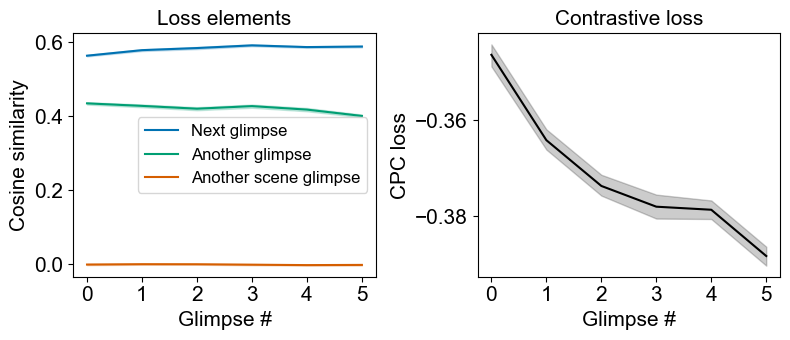

In [8]:
scene_loss = hyp['optimizer']['losses']['scene_loss']

# Define the time axis (using 1-indexing for gaze numbers)
time = np.arange(0, hyp['network']['timesteps'])

# Create a figure with two subplots arranged side by side,
# but this time we swap the order:
#   Left subplot: CPC loss elements
#   Right subplot: Joint CPC loss
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

# ---------------------------
# CPC loss elements subplot (left)
# ---------------------------
# When glimpse_loss is True, assume three arrays:
#   - cos_sim_target: "Next gaze"
#   - cos_sim_other_fix: "Another gaze"
#   - cos_sim_other_sc: "Another scene gaze"

if not scene_loss:
    if glimpse_loss:
        # Process curr fix
        df_curr_fix = pd.DataFrame(cos_sim_current_fix, columns=time)
        df_curr_fix = df_curr_fix.melt(var_name='Glimpse', value_name='Cosine similarity')
        df_curr_fix['Type'] = 'Current glimpse'

    # Process cos_sim_target_full
    df_target = pd.DataFrame(cos_sim_target, columns=time)
    df_target = df_target.melt(var_name='Glimpse', value_name='Cosine similarity')
    df_target['Type'] = 'Next glimpse'

    if glimpse_loss:
        # Process cos_sim_other_fix_full
        df_other_fix = pd.DataFrame(cos_sim_other_fix, columns=time)
        df_other_fix = df_other_fix.melt(var_name='Glimpse', value_name='Cosine similarity')
        df_other_fix['Type'] = 'Another glimpse'

    # Process cos_sim_other_sc_full
    df_other_sc = pd.DataFrame(cos_sim_other_sc, columns=time)
    df_other_sc = df_other_sc.melt(var_name='Glimpse', value_name='Cosine similarity')
    df_other_sc['Type'] = 'Another scene glimpse'

    # Combine into one long-form DataFrame
    df_elements = pd.concat([df_target, df_other_fix, df_other_sc], ignore_index=True) if glimpse_loss else pd.concat([df_target, df_other_sc], ignore_index=True)
    if scene_loss:
        df_misc = pd.concat([df_curr_fix], ignore_index=True)

    ax = axes[0]
    sns.lineplot(data=df_elements, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95), ax=ax)
    if scene_loss:
        sns.lineplot(data=df_misc, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95), ax=ax, alpha=0.25, linestyle='--',err_kws={'alpha': 0.1})
    ax.set_xticks(time)
    ax.set_xlabel('Glimpse #', fontsize=15)
    ax.set_ylabel('Cosine similarity', fontsize=15)
    ax.set_title('Loss elements', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(fontsize=12, loc='center right')

# ---------------------------
# Joint CPC loss subplot (right)
# ---------------------------
# Create a DataFrame from cos_sim_diff with columns corresponding to time steps,
# then melt it into long form and apply the negative as in the original code.
df_diff = pd.DataFrame(cos_sim_diff, columns=time) if glimpse_loss or semantic_loss else pd.DataFrame(bce_loss, columns=time)
df_diff_melt = df_diff.melt(var_name='Glimpse', value_name='CPC loss')
df_diff_melt['CPC loss'] = -df_diff_melt['CPC loss'] if glimpse_loss or semantic_loss else df_diff_melt['CPC loss']

ax = axes[1]
sns.lineplot(data=df_diff_melt, x='Glimpse', y='CPC loss', errorbar=('ci', 95), ax=ax, color='k')
ax.set_xticks(time)
ax.set_xlabel('Glimpse #', fontsize=15)
ax.set_ylabel('CPC loss', fontsize=15)
ax.set_title('Contrastive loss', fontsize=15) if glimpse_loss or semantic_loss else ax.set_title('Binary cross-entropy loss', fontsize=15)
ax.tick_params(axis='both', labelsize=15)

plt.tight_layout()
plt.show()

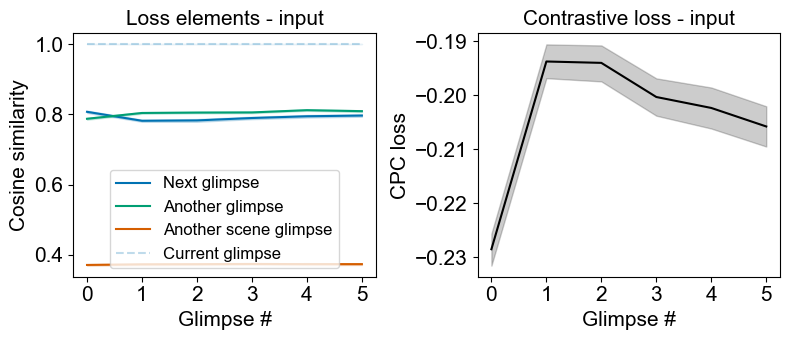

In [9]:
if glimpse_loss:
    # Define the time axis (using 1-indexing for gaze numbers)
    time = np.arange(0, hyp['network']['timesteps'])

    # Create a figure with two subplots arranged side by side,
    # but this time we swap the order:
    #   Left subplot: CPC loss elements
    #   Right subplot: Joint CPC loss
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

    # ---------------------------
    # CPC loss elements subplot (left)
    # ---------------------------
    # When glimpse_loss is True, assume three arrays:
    #   - cos_sim_target: "Next gaze"
    #   - cos_sim_other_fix: "Another gaze"
    #   - cos_sim_other_sc: "Another scene gaze"

    # Process curr fix
    df_curr_fix = pd.DataFrame(cos_sim_current_fix_in, columns=time)
    df_curr_fix = df_curr_fix.melt(var_name='Glimpse', value_name='Cosine similarity')
    df_curr_fix['Type'] = 'Current glimpse'

    # Process cos_sim_target_full
    df_target = pd.DataFrame(cos_sim_target_in, columns=time)
    df_target = df_target.melt(var_name='Glimpse', value_name='Cosine similarity')
    df_target['Type'] = 'Next glimpse'

    # Process cos_sim_other_fix_full
    df_other_fix = pd.DataFrame(cos_sim_other_fix_in, columns=time)
    df_other_fix = df_other_fix.melt(var_name='Glimpse', value_name='Cosine similarity')
    df_other_fix['Type'] = 'Another glimpse'

    # Process cos_sim_other_sc_full
    df_other_sc = pd.DataFrame(cos_sim_other_sc_in, columns=time)
    df_other_sc = df_other_sc.melt(var_name='Glimpse', value_name='Cosine similarity')
    df_other_sc['Type'] = 'Another scene glimpse'

    # Combine into one long-form DataFrame
    df_elements = pd.concat([df_target, df_other_fix, df_other_sc], ignore_index=True)
    df_misc = pd.concat([df_curr_fix], ignore_index=True)

    ax = axes[0]
    sns.lineplot(data=df_elements, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95), ax=ax)
    sns.lineplot(data=df_misc, x='Glimpse', y='Cosine similarity', hue='Type', errorbar=('ci', 95), ax=ax, alpha=0.25, linestyle='--',err_kws={'alpha': 0.1})
    ax.set_xticks(time)
    ax.set_xlabel('Glimpse #', fontsize=15)
    ax.set_ylabel('Cosine similarity', fontsize=15)
    ax.set_title('Loss elements - input', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(fontsize=12)

    # ---------------------------
    # Joint CPC loss subplot (right)
    # ---------------------------
    # Create a DataFrame from cos_sim_diff with columns corresponding to time steps,
    # then melt it into long form and apply the negative as in the original code.
    df_diff = pd.DataFrame(cos_sim_diff_in, columns=time)
    df_diff_melt = df_diff.melt(var_name='Glimpse', value_name='CPC loss')
    df_diff_melt['CPC loss'] = -df_diff_melt['CPC loss']

    ax = axes[1]
    sns.lineplot(data=df_diff_melt, x='Glimpse', y='CPC loss', errorbar=('ci', 95), ax=ax, color='k')
    ax.set_xticks(time)
    ax.set_xlabel('Glimpse #', fontsize=15)
    ax.set_ylabel('CPC loss', fontsize=15)
    ax.set_title('Contrastive loss - input', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)

    plt.tight_layout()
    plt.show()

    # fig.savefig(
    #     f'figures/CPC_plot_{net_name}.svg',
    #     format='svg',
    #     bbox_inches='tight',
    #     dpi=150.
    # )

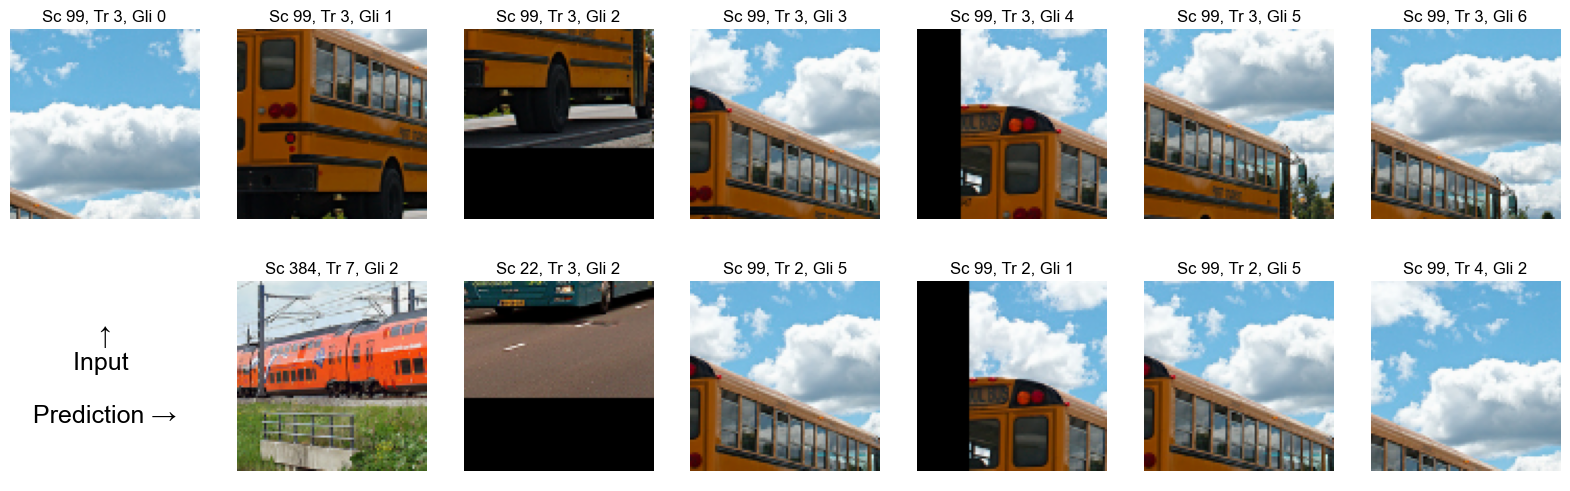

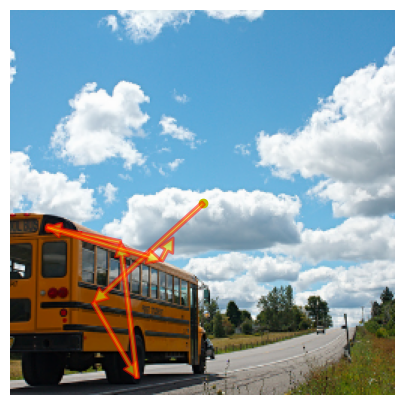

In [10]:
if glimpse_loss:

    # Show examples of spatially-specific prediction during rollouts

    sample_from_new_scenes = False # this will sample glimpses from new scenes, not the one we started with to explore the model's behavior
    autoregressive = False # this will use an autoregressive mode, which is unnatual for GPN, but can be used to explore the model's behavior

    # Choose a scene to start with
    scene_idx_start = np.random.choice(np.unique(all_traces_img_n))
    trace_idx_here = np.random.choice(np.unique(all_traces_trace_n[all_traces_img_n == scene_idx_start]))

    # In case we want to sample from a specific scene and trace
    scene_idx_start = 99 # 302 is the elephant scene, 99 for bus, 500 sink, 350 baseball
    trace_idx_here = 3

    tr_embed_idx = np.argwhere((all_traces_img_n == scene_idx_start) & (all_traces_trace_n == trace_idx_here))[0][0] # choosing glimpse 0

    img_size_expected = img_size
    saccades_here = all_traces_next_fix_rel_coords[(all_traces_img_n == scene_idx_start) & (all_traces_trace_n == trace_idx_here),:]

    # Pass 1 saccade with first glimpse of scene_idx_start scene and its trace_idx_here trace into the GP, check which glimpses in all_traces_embed, which correspond to other scenes than scene_idx_start, have the highest cosine similarity with the output, then continue with the next saccade and glimpse (making sure we never sample from the same scene from which a glimpse is sampled), and so on, until all saccades are exhausted; during this iterative procedure, create new input glimpse sequences by concatenating the glimpses we recovered in this procedure and passing them all together to get a "conditioned" output every time

    tr_embed_idxs_visited = [0 for i in range(saccades_here.shape[0]+1)]
    tr_embed_idxs_visited[0] = tr_embed_idx
    tr_embed_idxs_actual = [0 for i in range(saccades_here.shape[0]+1)]
    tr_embed_idxs_actual[0] = tr_embed_idx

    actvs = torch.tensor(all_traces_embed[(all_traces_img_n == scene_idx_start) & (all_traces_trace_n == trace_idx_here),:][0,:], dtype=torch.float32).unsqueeze(0).unsqueeze(1) # passing glimpse 0
    actvs = actvs.to(hyp['optimizer']['device'])
    if 'e2e' not in net_abbrv:  
        _, outputs = net(actvs, hyp['optimizer']['losses']['provide_loc']*torch.tensor(saccades_here[0,:], dtype=torch.float32).unsqueeze(0).unsqueeze(1))
    else:
        _, outputs, _ = net(actvs=actvs, coord_seq=hyp['optimizer']['losses']['provide_loc']*torch.tensor(saccades_here[0,:], dtype=torch.float32).unsqueeze(0).unsqueeze(1),input_actvs=True)
    outputs_here = outputs[0].detach().numpy().squeeze()
    outputs_actual = all_traces_embed[(all_traces_img_n == scene_idx_start) & (all_traces_trace_n == trace_idx_here),:]

    for glimpse_pass in range(saccades_here.shape[0]):

        # Find the glimpse with the highest cosine similarity with the output
        cos_sims_here = np.dot(outputs_here, all_traces_embed.T)/(norm(outputs_here)*norm(all_traces_embed, axis=1))
        for tr_idx in tr_embed_idxs_visited:
            tr_idx_scene_idx = all_traces_img_n[tr_idx]
            if sample_from_new_scenes:
                cos_sims_here[(all_traces_img_n == tr_idx_scene_idx)] = -np.inf
        tr_embed_idx_next = np.argmax(cos_sims_here)
        tr_embed_idxs_visited[glimpse_pass+1] = tr_embed_idx_next
        tr_embed_idxs_actual[glimpse_pass+1] = tr_embed_idxs_actual[glimpse_pass] + 1 if glimpse_pass < saccades_here.shape[0]-1 else None

        if glimpse_pass < saccades_here.shape[0]-1:
            # Concatenate the glimpses and pass through GPN
            actvs = torch.tensor(all_traces_embed[tr_embed_idxs_visited[:glimpse_pass+2],:], dtype=torch.float32).unsqueeze(0) if autoregressive else torch.tensor(all_traces_embed[(all_traces_img_n == scene_idx_start) & (all_traces_trace_n == trace_idx_here),:][:glimpse_pass+2,:], dtype=torch.float32).unsqueeze(0)
            actvs = actvs.to(hyp['optimizer']['device'])
            if 'e2e' not in net_abbrv:
                _, outputs = net(actvs, hyp['optimizer']['losses']['provide_loc']*torch.tensor(saccades_here[:glimpse_pass+2,:], dtype=torch.float32).unsqueeze(0))
            else:
                _, outputs, _ = net(actvs=actvs, coord_seq=hyp['optimizer']['losses']['provide_loc']*torch.tensor(saccades_here[:glimpse_pass+2,:], dtype=torch.float32).unsqueeze(0),input_actvs=True)
            outputs_here = outputs[0][:,-1,:].detach().numpy().squeeze()

    tr_scene_idxs_visited = [int(all_traces_img_n[tr_embed_idx]) for tr_embed_idx in tr_embed_idxs_visited]
    tr_trace_idxs_visited = [int(all_traces_trace_n[tr_embed_idx]) for tr_embed_idx in tr_embed_idxs_visited]
    tr_glimpse_idxs_visited = [int(all_traces_glimpse_n[tr_embed_idx]) for tr_embed_idx in tr_embed_idxs_visited]

    # Get the glimpses
    glimpse_cutouts, scene_starter = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=tr_scene_idxs_visited, trace_ids=tr_trace_idxs_visited, glimpse_ids=tr_glimpse_idxs_visited, glimpse_ext=glimpse_size, bbv=hyp['dataset']['bbv'], gaze_type=hyp['network']['gaze_type']) if 'e2e' not in net_abbrv else get_coco515_dg3_glimpse_cutouts_and_scene_e2e(scene_ids=tr_scene_idxs_visited, trace_ids=tr_trace_idxs_visited, glimpse_ids=tr_glimpse_idxs_visited, glimpse_ext=glimpse_size)

    tr_scene_idxs_actual = [int(all_traces_img_n[tr_embed_idx]) if tr_embed_idx is not None else int(all_traces_img_n[tr_embed_idxs_actual[n-1]]) for (n, tr_embed_idx) in enumerate(tr_embed_idxs_actual)]
    tr_trace_idxs_actual = [int(all_traces_trace_n[tr_embed_idx]) if tr_embed_idx is not None else int(all_traces_trace_n[tr_embed_idxs_actual[n-1]]) for (n, tr_embed_idx) in enumerate(tr_embed_idxs_actual)]
    tr_glimpse_idxs_actual = [int(all_traces_glimpse_n[tr_embed_idx]) if tr_embed_idx is not None else int(all_traces_glimpse_n[tr_embed_idxs_actual[n-1]])+1 for (n, tr_embed_idx) in enumerate(tr_embed_idxs_actual)]

    glimpse_cutouts_actual, _ = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=tr_scene_idxs_actual, trace_ids=tr_trace_idxs_actual, glimpse_ids=tr_glimpse_idxs_actual, glimpse_ext=glimpse_size, bbv=hyp['dataset']['bbv'], gaze_type=hyp['network']['gaze_type']) if 'e2e' not in net_abbrv else get_coco515_dg3_glimpse_cutouts_and_scene_e2e(scene_ids=tr_scene_idxs_actual, trace_ids=tr_trace_idxs_actual, glimpse_ids=tr_glimpse_idxs_actual, glimpse_ext=glimpse_size)

    # show the glimpses from glimpse_cutouts
    fig, axs = plt.subplots(2, len(glimpse_cutouts), figsize=(20, 6))
    for i, glimpse_cutout in enumerate(glimpse_cutouts):
        if i > 0:
            axs[1,i].imshow(glimpse_cutout)
            axs[1,i].axis('off')
            axs[1,i].set_title(f'Sc {tr_scene_idxs_visited[i]}, Tr {tr_trace_idxs_visited[i]}, Gli {tr_glimpse_idxs_visited[i]}', fontsize=12)
        else:
            axs[1,i].axis('off')
            axs[1,i].text(0.5, 0.5, '↑\nInput \n\nPrediction →', fontsize=18, ha='center', va='center')
        axs[0,i].imshow(glimpse_cutouts_actual[i])
        axs[0,i].axis('off')
        axs[0,i].set_title(f'Sc {tr_scene_idxs_actual[i]}, Tr {tr_trace_idxs_actual[i]}, Gli {tr_glimpse_idxs_actual[i]}', fontsize=12)
    axs[1,i].axis('off')

    plt.savefig(f'figures/sample_glimpses_and_predictions.svg',
        format='svg',
        dpi=150.
    )
    # plt.savefig(f'figures/sample_glimpses_and_predictions.png',
    #     format='png',
    #     dpi=300.
    # )

    # show the scene starter and the saccades
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(scene_starter)
    ax.axis('off')
    # Start point
    start_x, start_y = 128, 128
    ax.plot(start_x, start_y, 'o', color='y')
    # Draw each saccade as an arrow ending exactly at the saccade destination
    now_here = [start_x, start_y]
    for saccade in saccades_here:
        next_here = [now_here[0] + saccade[0], now_here[1] + saccade[1]]
        ax.annotate(
            '',
            xy=next_here,
            xytext=now_here,
            arrowprops=dict(
            arrowstyle='Simple, tail_width=0.25, head_width=1, head_length=1',
            edgecolor='r',
            facecolor='yellow',
            lw=2,
            shrinkA=0,
            shrinkB=0,
            alpha=0.5,
        )
        )
        now_here = next_here

    plt.savefig(f'figures/sample_scene_with_fixations.svg',
        format='svg',
        dpi=300.
    )
    # plt.savefig(f'figures/sample_scene_with_fixations.png',
    #     format='png',
    #     dpi=300.
    # )


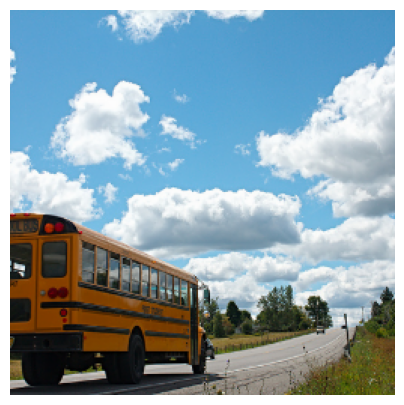

In [11]:
if glimpse_loss:

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(scene_starter)
    ax.axis('off')
    plt.savefig(f'figures/sample_scene_starter.svg',
        format='svg',
        dpi=300.
    )

### Prior: Assessing spatial binding of glimpses

Scene image size: 256
Glimpse size: 91

Top saccade, top - bot glimpses TtestResult(statistic=4.1589696026780265, pvalue=0.000739316797558539, df=16.0)
Bottom saccade, top - bot glimpses TtestResult(statistic=-7.911467000957227, pvalue=6.404828633231839e-07, df=16.0)
Left saccade, left - right glimpses TtestResult(statistic=-0.09798442645824312, pvalue=0.9231616689013645, df=16.0)
Right saccade, left - right glimpses TtestResult(statistic=-0.17769142801056156, pvalue=0.8611954576445222, df=16.0)


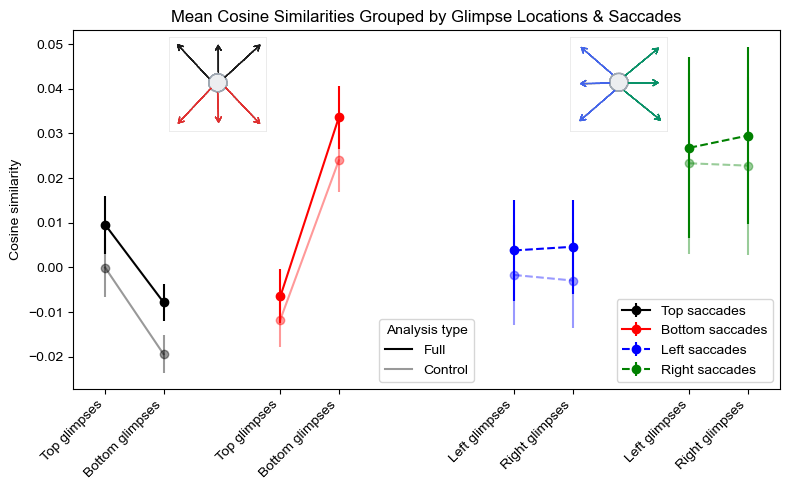

In [12]:
if glimpse_loss:

    # From a random starting glimpse (mean image as above), generate saccades to the centres of a 3x3 grid spanning the 256px image, get output, compare it with all other glimpse embeddings grouped according to which box their absolute position lies in, get mean cosine similarity per box-grouped glimpses per saccade, and plot the mean cosine similarities per box-grouped glimpses per saccade

    print('Scene image size:', img_size)
    print('Glimpse size:', glimpse_size)
    # Generate saccades - sweeping rows from left to right, top to bottom
    saccades_prior = []
    for i in range(3):
        for j in range(3):
            saccade = np.array([j*img_size/3+img_size/3/2, i*img_size/3+img_size/3/2]) - np.array([img_size/2, img_size/2]) # coordinates are arranged positively starting from top-left of the image
            saccades_prior.append(saccade)
    saccades_prior = np.array(saccades_prior)

    # Get mean glimpse embedding
    # mean_embedding = all_traces_embed.mean(axis=0).squeeze()
    mean_embedding = all_traces_embed[all_traces_glimpse_n == 0].mean(axis=0).squeeze() # only avg over the first, central, glimpses
    # mean_image = (images[0]*0.+255).astype(np.uint8)
    # mean_embedding = get_RN50_embeddings(mean_image[None, ...])

    # Pass through GPN
    actvs = torch.tensor(mean_embedding, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    actvs = actvs.to(hyp['optimizer']['device'])
    outputs_prior = []
    for idx in range(9):
        if 'e2e' not in net_abbrv:
            _, outputs = net(actvs, torch.tensor(saccades_prior[idx], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
        else:
            _, outputs, _ = net(actvs=actvs, coord_seq=torch.tensor(saccades_prior[idx], dtype=torch.float32).unsqueeze(0).unsqueeze(0),input_actvs=True)
        outputs_prior.append(outputs[0].detach().numpy().squeeze())
    outputs_prior = np.array(outputs_prior)

    # Compute cosine similarities
    cos_sims_prior = np.dot(outputs_prior, all_traces_embed.T)/(norm(outputs_prior)*norm(all_traces_embed, axis=1))

    # Group the similarities wrt box the glimpses' fix_coords fall in
    cos_sims_prior_grouped = np.zeros((3, 3, 9)) #xy, x down, y right
    cos_sims_prior_grouped_conservative = np.zeros((3, 3, 9)) # this is to ensure no "border effects" are present in the results that can signal location directly from embedding!

    conservative_ids = []
    for i in range(3):
        for j in range(3):
            mask_box = ((img_size/2+all_traces_fix_coords[:,0])//(img_size/3) == j) & ((img_size/2+all_traces_fix_coords[:,1])//(img_size/3) == i)
            mask_box_conservative = ((img_size/2+all_traces_fix_coords[:,0])//(img_size/3) == j) & ((img_size/2+all_traces_fix_coords[:,1])//(img_size/3) == i) & (img_size/2+all_traces_fix_coords[:,0] > glimpse_size/2) & (img_size/2+all_traces_fix_coords[:,0] < img_size-glimpse_size/2) & (img_size/2+all_traces_fix_coords[:,1] > glimpse_size/2) & (img_size/2+all_traces_fix_coords[:,1] < img_size-glimpse_size/2)
            for k in range(9):
                cos_sims_prior_grouped[i, j, k] = cos_sims_prior[k, mask_box].mean()
                cos_sims_prior_grouped_conservative[i, j, k] = cos_sims_prior[k, mask_box_conservative].mean()
            for idxs in np.where(mask_box_conservative)[0]:
                    conservative_ids.append(idxs)
    conservative_ids = sorted([int(i) for i in set(conservative_ids)])

    # Sort conservative ids wrt their max alignment with top/bottom saccades respectively
    conservative_ids_sorting_topness = np.argsort(cos_sims_prior[:3, conservative_ids].max(axis=0))[::-1].astype(int)
    conservative_ids_sorting_botness = np.argsort(cos_sims_prior[6:9, conservative_ids].max(axis=0))[::-1].astype(int)
    conservative_ids_sorting_leftness = np.argsort(cos_sims_prior[np.ix_([0,3,6], conservative_ids)].max(axis=0))[::-1].astype(int)
    conservative_ids_sorting_rightness = np.argsort(cos_sims_prior[np.ix_([2,5,8], conservative_ids)].max(axis=0))[::-1].astype(int)

    # Plot the mean cosine similarities per box-grouped glimpses per saccade, grouped by ordinate direction
    fig = plt.figure(figsize=(8, 5))
    # Plot cosine similarities for top and bottom glimpses
    plt.errorbar(
        np.arange(2),
        cos_sims_prior_grouped[[0, 2], :, :3].mean(axis=(1, 2)),
        yerr=1.96 * cos_sims_prior_grouped[[0, 2], :, :3].std(axis=(1, 2)) / np.sqrt(9),
        fmt='ko-', label='Top saccades'
    )
    plt.errorbar(
        np.arange(2)+0,
        cos_sims_prior_grouped_conservative[[0, 2], :, :3].mean(axis=(1, 2)),
        yerr=1.96 * cos_sims_prior_grouped[[0, 2], :, :3].std(axis=(1, 2)) / np.sqrt(9),
        fmt='ko-', alpha=0.4
    )
    plt.errorbar(
        np.arange(2) + 3,
        cos_sims_prior_grouped[[0, 2], :, 6:9].mean(axis=(1, 2)),
        yerr=1.96 * cos_sims_prior_grouped[[0, 2], :, 6:9].std(axis=(1, 2)) / np.sqrt(9),
        fmt='ro-', label='Bottom saccades'
    )
    plt.errorbar(
        np.arange(2) + 3,
        cos_sims_prior_grouped_conservative[[0, 2], :, 6:9].mean(axis=(1, 2)),
        yerr=1.96 * cos_sims_prior_grouped[[0, 2], :, 6:9].std(axis=(1, 2)) / np.sqrt(9),
        fmt='ro-', alpha=0.4
    )
    # Plot cosine similarities for left and right glimpses
    subarray_h = cos_sims_prior_grouped[:, [0, 2], :]
    subarray_h_conservative = cos_sims_prior_grouped_conservative[:, [0, 2], :]
    plt.errorbar(
        np.arange(2) + 7,
        subarray_h[:, :, [0, 3, 6]].mean(axis=(0, 2)),
        yerr=1.96 * subarray_h[:, :, [0, 3, 6]].std(axis=(0, 2)) / np.sqrt(9),
        fmt='bo--', label='Left saccades'
    )
    plt.errorbar(
        np.arange(2) + 7,
        subarray_h_conservative[:, :, [0, 3, 6]].mean(axis=(0, 2)),
        yerr=1.96 * subarray_h[:, :, [0, 3, 6]].std(axis=(0, 2)) / np.sqrt(9),
        fmt='bo--', alpha=0.4
    )
    plt.errorbar(
        np.arange(2) + 10,
        subarray_h[:, :, [2, 5, 8]].mean(axis=(0, 2)),
        yerr=1.96 * subarray_h[:, :, [2, 5, 8]].std(axis=(0, 2)) / np.sqrt(9),
        fmt='go--', label='Right saccades'
    )
    plt.errorbar(
        np.arange(2) + 10,
        subarray_h_conservative[:, :, [2, 5, 8]].mean(axis=(0, 2)),
        yerr=1.96 * subarray_h[:, :, [2, 5, 8]].std(axis=(0, 2)) / np.sqrt(9),
        fmt='go--', alpha=0.4
    )
    # Add x-axis labels
    plt.xticks(
        [0, 1, 3, 4, 7, 8, 10, 11],
        ['Top glimpses', 'Bottom glimpses', 'Top glimpses', 'Bottom glimpses',
        'Left glimpses', 'Right glimpses', 'Left glimpses', 'Right glimpses'],
        rotation=45, ha='right'
    )
    plt.ylabel('Cosine similarity')
    plt.legend(loc='lower right')

    path_image = plt.imread('figures/horizontal_saccade_setup.png')
    imagebox = OffsetImage(path_image, zoom=0.2)
    ab = AnnotationBbox(imagebox, (0.772, 0.85), frameon=False, xycoords='axes fraction')
    plt.gca().add_artist(ab)

    path_image = plt.imread('figures/vertical_saccade_setup.png')
    imagebox = OffsetImage(path_image, zoom=0.2)
    ab = AnnotationBbox(imagebox, (0.205, 0.85), frameon=False, xycoords='axes fraction')
    plt.gca().add_artist(ab)

    # Add a separate legend box for 'Full' and 'Conservative'
    legend_elements = [
        Line2D([0], [0], color='k', linestyle='-', label='Full'),
        Line2D([0], [0], color='k', linestyle='-', label='Control', alpha=0.4)
    ]
    legend1 = plt.legend(handles=legend_elements, loc='lower center', title='Analysis type')
    plt.gca().add_artist(legend1)

    # Add the original legend box for the saccade types
    legend2 = plt.legend(loc='lower right')

    plt.title('Mean Cosine Similarities Grouped by Glimpse Locations & Saccades')
    plt.tight_layout()

    # plt.savefig(f'figures/analysis_abs_location_{net_name}.png', dpi=300)
    print('')

    print('Top saccade, top - bot glimpses', ttest_ind(cos_sims_prior_grouped[0, :, :3].flatten(), cos_sims_prior_grouped[2, :, :3].flatten()))
    print('Bottom saccade, top - bot glimpses', ttest_ind(cos_sims_prior_grouped[0, :, 6:9].flatten(), cos_sims_prior_grouped[2, :, 6:9].flatten()))
    print('Left saccade, left - right glimpses', ttest_ind(cos_sims_prior_grouped[:, 0, [0, 3, 6]].flatten(), cos_sims_prior_grouped[:, 2, [0, 3, 6]].flatten()))
    print('Right saccade, left - right glimpses', ttest_ind(cos_sims_prior_grouped[:, 0, [2, 5, 8]].flatten(), cos_sims_prior_grouped[:, 2, [2, 5, 8]].flatten()))

    # fig.savefig(
    #     f'figures/prior_glimpse_pos_plot_{net_name}.svg',
    #     format='svg',
    #     bbox_inches='tight',
    #     dpi=150.
    # )

In [13]:
if perform_glimpse_group_decoding and glimpse_loss:

    # Get the mean embeddings of the top and bottom glimpses
    top_glimpses = all_traces_embed[(128+all_traces_fix_coords[:,1]) < img_size_expected/2 - img_size_expected/3/2]
    bottom_glimpses = all_traces_embed[(128+all_traces_fix_coords[:,1]) > img_size_expected/2 + img_size_expected/3/2]
    left_glimpses = all_traces_embed[(128+all_traces_fix_coords[:,0]) < img_size_expected/2 - img_size_expected/3/2]
    right_glimpses = all_traces_embed[(128+all_traces_fix_coords[:,0]) > img_size_expected/2 + img_size_expected/3/2]

    # Check linear discriminability of top vs bottom, and of left vs right glimpses using cross-validated linear logistic regression
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score

    X = np.vstack([top_glimpses, bottom_glimpses])
    y = np.concatenate([np.zeros(top_glimpses.shape[0]), np.ones(bottom_glimpses.shape[0])])
    logreg = LogisticRegression(max_iter=1000)
    scores = cross_val_score(logreg, X, y, cv=5)
    print('Top vs Bottom glimpses linear discriminability:', scores.mean())

    X = np.vstack([left_glimpses, right_glimpses])
    y = np.concatenate([np.zeros(left_glimpses.shape[0]), np.ones(right_glimpses.shape[0])])
    logreg = LogisticRegression(max_iter=1000)
    scores = cross_val_score(logreg, X, y, cv=5)
    print('Left vs Right glimpses linear discriminability:', scores.mean())

    # save the data
    save_data = {
        'scores_top_bottom': scores.mean(),
        'scores_left_right': scores.mean(),
    }

    with open(f'saved_actvs/{net_name}_glimpse_group_decoding.pkl', 'wb') as f:
        pickle.dump(save_data, f)

    print(f'Saved glimpse group decoding data for {net_name}')

elif glimpse_loss:

    # Load the data
    with open(f'saved_actvs/{net_name}_glimpse_group_decoding.pkl', 'rb') as f:
        data = pickle.load(f)
    scores_top_bottom = data['scores_top_bottom']
    scores_left_right = data['scores_left_right']

    print(f'Loaded glimpse group decoding data for {net_name}')

    print('Top vs Bottom glimpses linear discriminability:', scores_top_bottom)
    print('Left vs Right glimpses linear discriminability:', scores_left_right) 

Loaded glimpse group decoding data for gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1
Top vs Bottom glimpses linear discriminability: 0.8263087783506224
Left vs Right glimpses linear discriminability: 0.8263087783506224


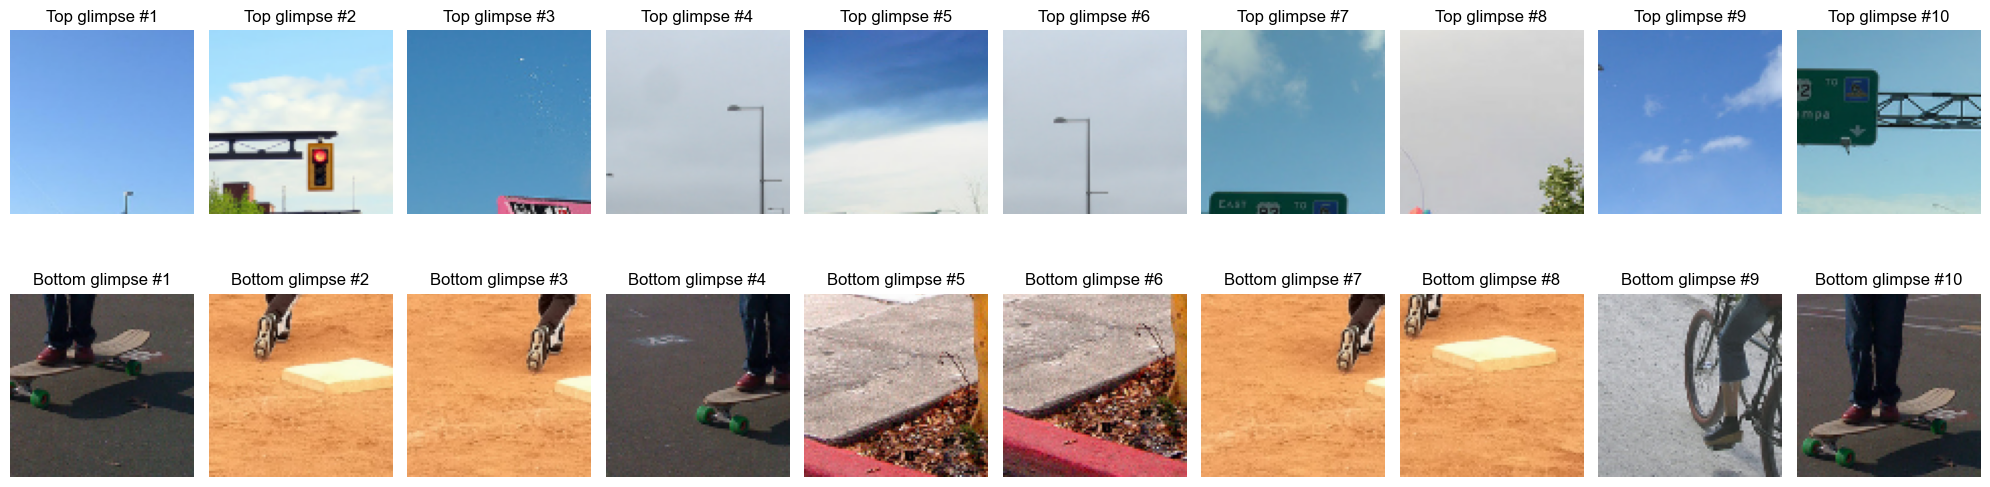

In [14]:
if glimpse_loss:

    # Visualize the exemplary top and bottom glimpses

    n_glimpses_extract = 10

    top_glimpses_chosen = [conservative_ids[i] for i in conservative_ids_sorting_topness[:n_glimpses_extract]]
    bottom_glimpses_chosen = [conservative_ids[i] for i in conservative_ids_sorting_botness[:n_glimpses_extract]]

    # get glimpses
    sc_id_h = [int(all_traces_img_n[gli_id]) for gli_id in top_glimpses_chosen]
    tr_id_h = [int(all_traces_trace_n[gli_id]) for gli_id in top_glimpses_chosen]
    gl_id_h = [int(all_traces_glimpse_n[gli_id]) for gli_id in top_glimpses_chosen]
    top_glimpses_h, _ = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=sc_id_h,trace_ids=tr_id_h,glimpse_ids=gl_id_h, bbv=hyp['dataset']['bbv'],gaze_type=hyp['network']['gaze_type']) if 'e2e' not in net_abbrv else get_coco515_dg3_glimpse_cutouts_and_scene_e2e(scene_ids=sc_id_h,trace_ids=tr_id_h,glimpse_ids=gl_id_h)

    sc_id_h = [int(all_traces_img_n[gli_id]) for gli_id in bottom_glimpses_chosen]
    tr_id_h = [int(all_traces_trace_n[gli_id]) for gli_id in bottom_glimpses_chosen]
    gl_id_h = [int(all_traces_glimpse_n[gli_id]) for gli_id in bottom_glimpses_chosen]
    bottom_glimpses_h, _ = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=sc_id_h,trace_ids=tr_id_h,glimpse_ids=gl_id_h, bbv=hyp['dataset']['bbv'],gaze_type=hyp['network']['gaze_type']) if 'e2e' not in net_abbrv else get_coco515_dg3_glimpse_cutouts_and_scene_e2e(scene_ids=sc_id_h,trace_ids=tr_id_h,glimpse_ids=gl_id_h)

    # Plot the top and bottom glimpses
    fig, axs = plt.subplots(2, n_glimpses_extract, figsize=(n_glimpses_extract*2, 6))
    for i, glimpse in enumerate(top_glimpses_h):
        axs[0, i].imshow(glimpse)
        axs[0, i].axis('off')
        axs[0, i].set_title(f'Top glimpse #{i+1}', fontsize=12)
    for i, glimpse in enumerate(bottom_glimpses_h):
        axs[1, i].imshow(glimpse)
        axs[1, i].axis('off')
        axs[1, i].set_title(f'Bottom glimpse #{i+1}', fontsize=12)
    plt.tight_layout()

### Prior: Assessing scene-object co-occurrence (SCEGRAM)

In [15]:
if extract_scegram_results and glimpse_loss:

    # IMP: SCEGRAM center crops are based on NSD glimpse extent currently!
    # load key 'coords' from h5 datasets/SCEGRAM/coords.h5

    df = pd.read_hdf("datasets/SCEGRAM/coords.h5", key="coords")
    # print(df)

    conds_vo = ['CON','SEM','SYN']
    n_scenes_vo = int(len(df)/len(conds_vo)/2)

    # Get the mean center crop embeddings for each scene
    scene_embeddings = np.zeros((n_scenes_vo, input_dim))
    images = []
    for i in range(n_scenes_vo):
        # read the crops from datasets/glimpses/center for each of the conds as "Scene{i+1}_ABS_{cond}.png"
        idx_real = i+1
        for cond in conds_vo:
            # read image and get embedding
            img = Image.open(f'datasets/SCEGRAM/center/Scene{idx_real}_ABS_{cond}.png')
            if 'e2e' in net_abbrv:
                img = img.resize((glimpse_size, glimpse_size))
            images.append(np.expand_dims(np.array(img), axis=0))
    images = np.vstack(images)
    embeddings = get_RN50_embeddings(images, bbv=hyp['dataset']['bbv']) if 'e2e' not in net_abbrv else net(glimpse_seq=torch.tensor(images, dtype=torch.float32).permute(0,3,1,2).unsqueeze(1).to(hyp['optimizer']['device']), only_rn=True).squeeze().cpu().detach().numpy()
    # embeddings_evd = get_RN50_EVD_embeddings(images)
    for i in range(n_scenes_vo):
        scene_embeddings[i,:] = embeddings[i*len(conds_vo):(i+1)*len(conds_vo)].mean(axis=0)
        # scene_embeddings[i,:,0] = embeddings.mean(axis=0)
    scene_embeddings_base = embeddings.mean(axis=0) 

    print("Scene center embeddings shape:", scene_embeddings.shape)

    # Get the embeddings for the crops of the objects
    object_embeddings = np.zeros((n_scenes_vo, len(conds_vo), input_dim))
    images = []
    for i in range(n_scenes_vo):
        # read the crops from datasets/glimpses/center for each of the conds as "Scene{i+1}_{cond}.png"
        idx_real = i+1
        for j, cond in enumerate(conds_vo):
            # read image and get embedding
            img = Image.open(f'datasets/SCEGRAM/object/Scene{idx_real}_{cond}.png')
            if 'e2e' in net_abbrv:
                img = img.resize((glimpse_size, glimpse_size))
            images.append(np.expand_dims(np.array(img), axis=0))
    images = np.vstack(images)
    embeddings = get_RN50_embeddings(images, bbv=hyp['dataset']['bbv']) if 'e2e' not in net_abbrv else net(glimpse_seq=torch.tensor(images, dtype=torch.float32).permute(0,3,1,2).unsqueeze(1).to(hyp['optimizer']['device']), only_rn=True).squeeze().cpu().detach().numpy()
    # embeddings_evd = get_RN50_EVD_embeddings(images)
    for i in range(n_scenes_vo):
        object_embeddings[i,:,:] = embeddings[i*len(conds_vo):(i+1)*len(conds_vo)]
    print("Object embeddings shape:", object_embeddings.shape)

    # Get the embeddings for the crops of the backgrounds without the objects
    bg_embeddings = np.zeros((n_scenes_vo, len(conds_vo), input_dim))
    images = []
    for i in range(n_scenes_vo):
        # read the crops from datasets/glimpses/center for each of the conds as "Scene{i+1}_ABS_{cond}.png"
        idx_real = i+1
        for j, cond in enumerate(conds_vo):
            # read image and get embedding
            img = Image.open(f'datasets/SCEGRAM/background/Scene{idx_real}_ABS_{cond}.png')
            if 'e2e' in net_abbrv:
                img = img.resize((glimpse_size, glimpse_size))
            images.append(np.expand_dims(np.array(img), axis=0))
    images = np.vstack(images)
    embeddings = get_RN50_embeddings(images, bbv=hyp['dataset']['bbv']) if 'e2e' not in net_abbrv else net(glimpse_seq=torch.tensor(images, dtype=torch.float32).permute(0,3,1,2).unsqueeze(1).to(hyp['optimizer']['device']), only_rn=True).squeeze().cpu().detach().numpy()
    for i in range(n_scenes_vo):
        bg_embeddings[i,:,:] = embeddings[i*len(conds_vo):(i+1)*len(conds_vo)]
    print("Background embeddings shape:", bg_embeddings.shape)

    # Get the embeddings for the crops of the isolated objects
    iso_objs = list(set(df['obj_file_name']))
    iso_objs = [obj for obj in iso_objs if obj != None]
    iso_obj_embeddings = np.zeros((len(iso_objs), input_dim))
    images = []
    for i, obj in enumerate(iso_objs):
        img = Image.open(f'datasets/SCEGRAM/isolated/{obj}')
        img = resize_and_center_crop(img)
        if 'e2e' in net_abbrv:
            img = img.resize((glimpse_size, glimpse_size))
        images.append(np.expand_dims(np.array(img), axis=0))
    images = np.vstack(images)
    embeddings = get_RN50_embeddings(images, bbv=hyp['dataset']['bbv']) if 'e2e' not in net_abbrv else net(glimpse_seq=torch.tensor(images, dtype=torch.float32).permute(0,3,1,2).unsqueeze(1).to(hyp['optimizer']['device']), only_rn=True).squeeze().cpu().detach().numpy()
    iso_obj_embeddings[:,:] = embeddings
    print("Isolated object embeddings shape:", iso_obj_embeddings.shape)

    # get saccades for each scene and cond from the center to the object
    saccades_vo = np.zeros((n_scenes_vo, len(conds_vo), 2))
    for i in range(n_scenes_vo):
        idx_real = i+1
        for j, cond in enumerate(conds_vo):
            saccades_vo[i, j, 0] = df["crop_x_center"][df["sce_file_name"] == f"Scene{idx_real}_{cond}.png"].values[0] - df["crop_x_center"][df["sce_file_name"] == f"Scene{idx_real}_ABS_{cond}.png"].values[0] 
            saccades_vo[i, j, 1] = df["crop_y_center"][df["sce_file_name"] == f"Scene{idx_real}_{cond}.png"].values[0] - df["crop_y_center"][df["sce_file_name"] == f"Scene{idx_real}_ABS_{cond}.png"].values[0]
    saccades_vo = saccades_vo/np.mean(df["img_height"].values)*img_size # convert to 256x256 image coordinates expected by GP
    print(f"Saccades to objects shape (converted to {img_size}): {saccades_vo.shape}")

    # Get predicted outputs for each scene center embedding and saccade and compare with the relevant object embeddings
    sim_vo_sem = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_sem_iso = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_sem_iso_input = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_sem_iso_rank = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_sem_iso_rank_input = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_sem_bg = np.zeros((n_scenes_vo, 2, 2))
    for i in range(n_scenes_vo):
        for j in range(2): # saccade type - CON or SEM
            for k in range(2): # actual center crop or avg center crop

                idx_real = i+1
                type_obj = df[df['sce_file_name']==f'Scene{idx_real}_CON.png']['obj_file_name'].values[0] if j == 0 else df[df['sce_file_name']==f'Scene{idx_real}_SEM.png']['obj_file_name'].values[0]

                saccade_h = saccades_vo[i, j]
                actvs = torch.tensor(scene_embeddings[i,:] if k == 1 else scene_embeddings.mean(axis=0), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                actvs = actvs.to(hyp['optimizer']['device'])
                _, outputs = net(actvs, torch.tensor(saccade_h, dtype=torch.float32).unsqueeze(0).unsqueeze(0)) if 'e2e' not in net_abbrv else net(actvs=actvs, coord_seq=torch.tensor(saccade_h, dtype=torch.float32).unsqueeze(0).unsqueeze(0),input_actvs=True)[0:2]
                outputs_vo_sem = outputs[0].detach().numpy().squeeze()
                sim_vo_sem[i, j, k] = np.dot(outputs_vo_sem, object_embeddings[i, j, :].T)/(norm(outputs_vo_sem)*norm(object_embeddings[i, j, :]))
                sim_vo_sem_bg[i, j, k] = np.dot(outputs_vo_sem, bg_embeddings[i, j, :].T)/(norm(outputs_vo_sem)*norm(bg_embeddings[i, j, :]))
                sim_vo_sem_iso[i, j, k] = np.dot(outputs_vo_sem, iso_obj_embeddings[iso_objs.index(type_obj), :].T)/(norm(outputs_vo_sem)*norm(iso_obj_embeddings[iso_objs.index(type_obj), :]))
                sim_vo_sem_iso_rank[i, j, k] = iso_obj_embeddings.shape[0] - np.where(np.argsort(np.dot(outputs_vo_sem, iso_obj_embeddings.T)/(norm(outputs_vo_sem)*norm(iso_obj_embeddings))) == iso_objs.index(type_obj))[0][0]

                sim_vo_sem_iso_input[i, j, k] = np.dot(actvs.numpy().squeeze(), iso_obj_embeddings[iso_objs.index(type_obj), :].T)/(norm(actvs)*norm(iso_obj_embeddings[iso_objs.index(type_obj), :]))
                sim_vo_sem_iso_rank_input[i, j, k] = iso_obj_embeddings.shape[0] - np.where(np.argsort(np.dot(actvs.numpy().squeeze(), iso_obj_embeddings.T)/(norm(actvs)*norm(iso_obj_embeddings))) == iso_objs.index(type_obj))[0][0]

    sim_vo_syn = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_syn_iso = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_syn_iso_rank = np.zeros((n_scenes_vo, 2, 2))
    sim_vo_syn_bg = np.zeros((n_scenes_vo, 2, 2))
    for i in range(n_scenes_vo):
        for j in range(2): # CON / SYN saccade
            for k in range(2): # actual center crop or avg center crop

                idx_real = i+1

                saccade_type = saccades_vo[i, j*2]
                actvs = torch.tensor(scene_embeddings[i,:] if k==1 else scene_embeddings.mean(axis=0), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                actvs = actvs.to(hyp['optimizer']['device'])
                _, outputs_type = net(actvs, torch.tensor(saccade_type, dtype=torch.float32).unsqueeze(0).unsqueeze(0)) if 'e2e' not in net_abbrv else net(actvs=actvs, coord_seq=torch.tensor(saccade_type, dtype=torch.float32).unsqueeze(0).unsqueeze(0),input_actvs=True)[0:2]
                outputs_vo_type = outputs_type[0].detach().numpy().squeeze()

                sim_vo_syn[i, j, k] = np.dot(outputs_vo_type, object_embeddings[i, j*2, :].T)/(norm(outputs_vo_type)*norm(object_embeddings[i, j*2, :]))
                sim_vo_syn_bg[i, j, k] = np.dot(outputs_vo_type, bg_embeddings[i, j*2, :].T)/(norm(outputs_vo_type)*norm(bg_embeddings[i, j*2, :]))

                type_obj = df[df['sce_file_name']==f'Scene{idx_real}_CON.png']['obj_file_name'].values[0] if j == 0 else df[df['sce_file_name']==f'Scene{idx_real}_SYN.png']['obj_file_name'].values[0]
                sim_vo_syn_iso[i, j, k] = np.dot(outputs_vo_type, iso_obj_embeddings[iso_objs.index(type_obj), :].T)/(norm(outputs_vo_type)*norm(iso_obj_embeddings[iso_objs.index(type_obj), :]))
                sim_vo_syn_iso_rank[i, j, k] = iso_obj_embeddings.shape[0] - np.where(np.argsort(np.dot(outputs_vo_type, iso_obj_embeddings.T)/(norm(outputs_vo_type)*norm(iso_obj_embeddings))) == iso_objs.index(type_obj))[0][0]

    # Save the results
    save_data = {
        'sim_vo_sem_iso': sim_vo_sem_iso,
        'sim_vo_sem_iso_input': sim_vo_sem_iso_input,
        'sim_vo_syn_iso': sim_vo_syn_iso,
        'n_scenes_vo': n_scenes_vo,
        'sim_vo_syn_iso_rank': sim_vo_syn_iso_rank,
        'sim_vo_sem_iso_rank': sim_vo_sem_iso_rank,
        'sim_vo_sem_iso_rank_input': sim_vo_sem_iso_rank_input,
        'sim_vo_sem': sim_vo_sem,
        'sim_vo_syn': sim_vo_syn,
        'sim_vo_sem_bg': sim_vo_sem_bg,
        'sim_vo_syn_bg': sim_vo_syn_bg,
        'iso_obj_embeddings': iso_obj_embeddings,
    }
    with open(f'saved_actvs/{net_name}_SCEGRAM_results.pkl', 'wb') as f:
        pickle.dump(save_data, f)
    print(f'Saved SCEGRAM results to saved_actvs/{net_name}_SCEGRAM_results.pkl')

elif glimpse_loss:

    with open(f'saved_actvs/{net_name}_SCEGRAM_results.pkl', 'rb') as f:
        save_data = pickle.load(f)
    sim_vo_sem_iso = save_data['sim_vo_sem_iso']
    sim_vo_sem_iso_input = save_data['sim_vo_sem_iso_input']
    sim_vo_syn_iso = save_data['sim_vo_syn_iso']
    n_scenes_vo = save_data['n_scenes_vo']
    sim_vo_syn_iso_rank = save_data['sim_vo_syn_iso_rank']
    sim_vo_sem_iso_rank = save_data['sim_vo_sem_iso_rank']
    sim_vo_sem_iso_rank_input = save_data['sim_vo_sem_iso_rank_input']
    sim_vo_sem = save_data['sim_vo_sem']
    sim_vo_syn = save_data['sim_vo_syn']
    sim_vo_sem_bg = save_data['sim_vo_sem_bg']
    sim_vo_syn_bg = save_data['sim_vo_syn_bg']
    iso_obj_embeddings = save_data['iso_obj_embeddings']
    print(f'Loaded SCEGRAM results from saved_actvs/{net_name}_SCEGRAM_results.pkl')

Loaded SCEGRAM results from saved_actvs/gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1_SCEGRAM_results.pkl


Testing the Semantic and Syntactic condition differences between actual and baseline runs...

Results of the hierarchical sign-permutation test (Holm-adjusted; union-of-4 at Level-3 if both Δ's open):
{'level1': {'obs': -0.017730278612841172, 'p_adj': 0.3194, 'p_raw': 0.3194},
 'level2': {'pooled_change': {'obs': 0.021117379928796465,
                              'p_adj': 0.0115,
                              'p_raw': 0.0115}},
 'level3': {'pooled_act': {'obs': 0.02495997624280594,
                           'p_adj': 0.0076,
                           'p_raw': 0.0038},
            'pooled_base': {'obs': 0.0038425963140094723,
                            'p_adj': 0.6892,
                            'p_raw': 0.6892}}}


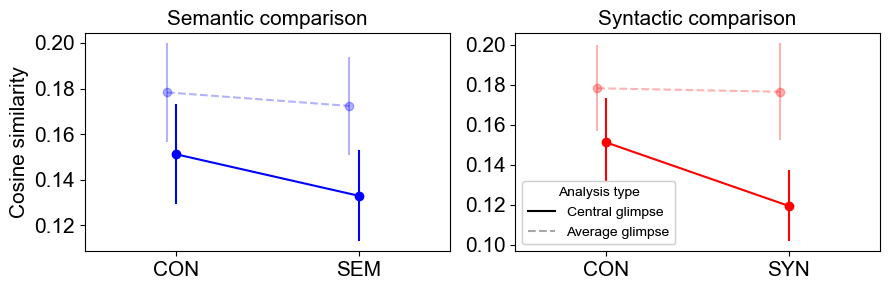

In [16]:
if glimpse_loss:

    # Plotting the cosine similarities

    fig = plt.figure(figsize=(9, 3))
    plt.subplot(1,2,1)
    plt.errorbar(
        np.arange(2),
        sim_vo_sem_iso[:,:,1].mean(axis=0),
        yerr=1.96 * sim_vo_sem_iso[:,:,1].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='bo-'
    )
    plt.errorbar(
        np.arange(2)-0.05,
        sim_vo_sem_iso[:,:,0].mean(axis=0),
        yerr=1.96 * sim_vo_sem_iso[:,:,0].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='bo--',
        alpha=0.3
    )
    plt.xlim(-0.5, 1.5)
    plt.xticks([0, 1], ['CON', 'SEM'], fontsize=15)
    plt.ylabel('Cosine similarity', fontsize=15)
    # plt.legend(loc='upper right')
    plt.title('Semantic comparison', fontsize=15)
    plt.yticks(fontsize=15)
    # plt.ylim(0.08,0.16)

    plt.subplot(1,2,2)
    plt.errorbar(
        np.arange(2),
        sim_vo_syn_iso[:,:,1].mean(axis=0),
        yerr=1.96 * sim_vo_syn_iso[:,:,1].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='ro-'
    )
    plt.errorbar(
        np.arange(2)-0.05,
        sim_vo_syn_iso[:,:,0].mean(axis=0),
        yerr=1.96 * sim_vo_syn_iso[:,:,0].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='ro--',
        alpha=0.3
    )
    plt.xlim(-0.5, 1.5)
    # plt.ylim(0.08,0.16)
    plt.xticks([0, 1], ['CON', 'SYN'], fontsize=15)
    # plt.ylabel('Cosine similarity')
    # plt.legend(loc='upper right')
    plt.title('Syntactic comparison', fontsize=15)
    plt.yticks(fontsize=15)
    # plt.yticks([])
    # Add a separate legend box for 'Full' and 'Conservative'
    legend_elements = [
        Line2D([0], [0], color='k', linestyle='-', label='Central glimpse'),
        Line2D([0], [0], color='k', linestyle='--', label='Average glimpse', alpha=0.3)
    ]
    legend1 = plt.legend(handles=legend_elements, loc='lower left', title='Analysis type')
    plt.gca().add_artist(legend1)

    plt.tight_layout()

    # fig.savefig(
    #     f'figures/prior_scegram_plot_{net_name}.svg',
    #     format='svg',
    #     bbox_inches='tight',
    #     dpi=150.
    # )

    # per-subject raw scores ------------------------------
    CON_act  = sim_vo_sem_iso[:,0,1]
    SEM_act  = sim_vo_sem_iso[:,1,1]
    SYN_act  = sim_vo_syn_iso[:,1,1]
    CON_base = sim_vo_sem_iso[:,0,0]
    SEM_base = sim_vo_sem_iso[:,1,0]
    SYN_base = sim_vo_syn_iso[:,1,0]

    # 1st “paired” comparison (CON vs SEM) ----------------
    D1_act  = CON_act  - SEM_act          # actual run
    D1_base = CON_base - SEM_base         # base run

    # 2nd “paired” comparison (CON vs SYN) ----------------
    D2_act  = CON_act  - SYN_act          # actual run
    D2_base = CON_base - SYN_base         # base run

    print("Testing the Semantic and Syntactic condition differences between actual and baseline runs...\n")
    results = perm_test_scegram(D1_act, D1_base, D2_act, D2_base, test_output='hierarchical')

Testing the Semantic and Syntactic condition differences between actual and baseline runs...

Results of the hierarchical sign-permutation test (Holm-adjusted; union-of-4 at Level-3 if both Δ's open):
{'level1': {'obs': 0.004483743724971855, 'p_adj': 0.3866, 'p_raw': 0.3866},
 'level2': {'pooled_change': {'obs': 0.010010368759889945,
                              'p_adj': 0.0976,
                              'p_raw': 0.0976}},
 'level3': {}}


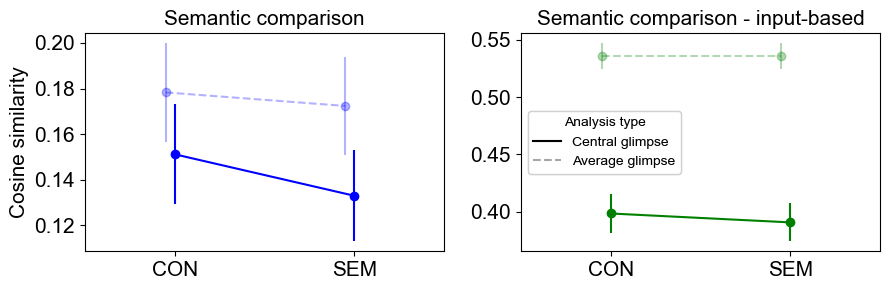

In [17]:
if glimpse_loss:
    
    fig = plt.figure(figsize=(9, 3))
    plt.subplot(1,2,1)
    plt.errorbar(
        np.arange(2),
        sim_vo_sem_iso[:,:,1].mean(axis=0),
        yerr=1.96 * sim_vo_sem_iso[:,:,1].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='bo-'
    )
    plt.errorbar(
        np.arange(2)-0.05,
        sim_vo_sem_iso[:,:,0].mean(axis=0),
        yerr=1.96 * sim_vo_sem_iso[:,:,0].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='bo--',
        alpha=0.3
    )
    plt.xlim(-0.5, 1.5)
    plt.xticks([0, 1], ['CON', 'SEM'], fontsize=15)
    plt.ylabel('Cosine similarity', fontsize=15)
    # plt.legend(loc='upper right')
    plt.title('Semantic comparison', fontsize=15)
    plt.yticks(fontsize=15)
    # plt.ylim(0.08,0.16)

    plt.subplot(1,2,2)
    plt.errorbar(
        np.arange(2),
        sim_vo_sem_iso_input[:,:,1].mean(axis=0),
        yerr=1.96 * sim_vo_sem_iso_input[:,:,1].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='go-',
    )
    plt.errorbar(
        np.arange(2)-0.05,
        sim_vo_sem_iso_input[:,:,0].mean(axis=0),
        yerr=1.96 * sim_vo_sem_iso_input[:,:,0].std(axis=0) / np.sqrt(n_scenes_vo),
        fmt='go--',
        alpha=0.3
    )
    plt.xlim(-0.5, 1.5)
    # plt.ylim(0.08,0.16)
    plt.xticks([0, 1], ['CON', 'SEM'], fontsize=15)
    # plt.ylabel('Cosine similarity')
    # plt.legend(loc='upper right')
    plt.title('Semantic comparison - input-based', fontsize=15)
    plt.yticks(fontsize=15)
    # plt.yticks([])
    # Add a separate legend box for 'Full' and 'Conservative'
    legend_elements = [
        Line2D([0], [0], color='k', linestyle='-', label='Central glimpse'),
        Line2D([0], [0], color='k', linestyle='--', label='Average glimpse', alpha=0.3)
    ]
    legend1 = plt.legend(handles=legend_elements, loc='center left', title='Analysis type')
    plt.gca().add_artist(legend1)

    plt.tight_layout()

    # per-subject raw scores ------------------------------
    CON_act  = sim_vo_sem_iso[:,0,1]
    SEM_act  = sim_vo_sem_iso[:,1,1]
    CON_act_input = sim_vo_sem_iso_input[:,0,1]
    SEM_act_input = sim_vo_sem_iso_input[:,1,1]
    CON_base = sim_vo_sem_iso[:,0,0]
    SEM_base = sim_vo_sem_iso[:,1,0]
    CON_base_input = sim_vo_sem_iso_input[:,0,0]
    SEM_base_input = sim_vo_sem_iso_input[:,1,0]

    # 1st “paired” comparison (CON vs SEM) ----------------
    D1_act  = CON_act  - SEM_act          # actual run
    D1_base = CON_base - SEM_base         # base run

    # 2nd “paired” comparison input-based ----------------
    D2_act  = CON_act_input  - SEM_act_input          # actual run
    D2_base = CON_base_input - SEM_base_input         # base run

    print("Testing the Semantic and Syntactic condition differences between actual and baseline runs...\n")
    results = perm_test_scegram(D1_act, D1_base, D2_act, D2_base, test_output='hierarchical')

### ICL: Inference of unseen relationships between glimpses in novel scenes

In [18]:
saccade_type = 'natural' # natural/square
unroll_type = 'local' # local/hierarchical - hierarchical is where we step through glimpses again without providng glimpse inputs! (stronger test - a la Rowan)

gaze_type = hyp['network']['gaze_type']

if simulate_glimpses_icl and glimpse_loss:

    # Generate random glimpse representations and square-like navigation through them, pass them through LSTM_GP and assess the output

    n_scenes = 250 # we found ~280 natural scene traces we can find
    n_glimpses = 4
    
    # Choosing random natural glimpses and placing them together to construct random scenes
    n_glimpses_natural_data = np.vstack(actv_reps).shape[0]*np.vstack(actv_reps).shape[1]
    choose_glimpses = np.random.choice(n_glimpses_natural_data, n_scenes*n_glimpses, replace=False)
    glimpse_reps_natural = np.vstack(actv_reps).reshape(n_glimpses_natural_data, -1)[choose_glimpses,:].reshape(n_scenes, n_glimpses, -1)

    example_scene_glimpse_ids = choose_glimpses[:n_glimpses] 

    # Generate random glimpse representations with numbers sampled from glimpse_reps_natural - distribution of embeddings maintained
    glimpse_reps_random = np.random.choice(glimpse_reps_natural.flatten(), n_scenes*n_glimpses*glimpse_reps_natural.shape[2]).reshape(n_scenes, n_glimpses, -1)

    # Get random scenes that do not have refixations and get sample saccade directions
    choice_scenes = []
    refixation_threshold = glimpse_size/2 # move at least glimpse_ext/3 pixels
    for idx in range(n_scenes):
        count = 0
        while True:
            choice_scene = np.random.choice(np.vstack(next_fix_rel_coords_all).shape[0], 1, replace=False)
            count += 1
            if count > np.array(n_samples_batch).sum(): # 5150 traces*scenes for test_515
                print('Could not find a scene without refixation')
                print('Number of scenes without refixation found:', len(choice_scenes))
                break
            if choice_scene not in choice_scenes:
                count_norefix = 0 # now check that the pairwise distances between the glimpses are larger than refixation_threshold
                if np.linalg.norm(np.vstack(fix_coords_all)[choice_scene, 1:n_glimpses, :], axis=-1).min() > refixation_threshold:
                    count_norefix += 1
                for ij in range(1,n_glimpses-1):
                    if np.linalg.norm(np.vstack(fix_coords_all)[choice_scene, ij+1:n_glimpses, :]-np.vstack(fix_coords_all)[choice_scene, ij, :], axis=-1).min() > refixation_threshold:
                        count_norefix += 1
                if count_norefix == n_glimpses-1:
                    choice_scenes.append(choice_scene)
                    break
    choice_scenes = np.array(choice_scenes)[:,0]
    print('Number of scenes without refixation used:', len(choice_scenes))
    # choice_scenes = np.random.choice(np.vstack(next_fix_rel_coords_all).shape[0], n_scenes, replace=False)

    # Choosing the original glimpse representations
    glimpse_reps_actual = np.vstack(actv_reps)[choice_scenes,:n_glimpses+1,:] # getting the next glimpse for control 

    if saccade_type == 'square':
        # Generate square-like saccade directions
        saccade_magnitude = 50
        if unroll_type == 'local':
            saccade_dirs_b1 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1]])*91
            saccade_dirs_b2 = np.array([[1, 0], [0, -1], [-1, 0], [1, 1]])*91
            saccade_dirs_b3 = np.array([[1, 0], [0, -1], [-1, 0], [1, 0]])*91
            saccade_dirs_b4 = np.array([[1, 0], [0, -1], [-1, 0], [0, 0]])*91
        elif unroll_type == 'hierarchical':
            saccade_dirs_b1 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1]])*saccade_magnitude
            saccade_dirs_b2 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1], [1, 0]])*saccade_magnitude
            saccade_dirs_b3 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1], [1, 0], [0, -1]])*saccade_magnitude
            saccade_dirs_b4 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1], [1, 0], [0, -1], [-1, 0]])*saccade_magnitude
        # Repeat these saccade dirs for all scenes, with scenes as batch dimension
        saccade_dirs_b_mut = []
        saccade_dirs_b_mut.append(np.repeat(saccade_dirs_b1[np.newaxis, :, :], n_scenes, axis=0))
        saccade_dirs_b_mut.append(np.repeat(saccade_dirs_b2[np.newaxis, :, :], n_scenes, axis=0))
        saccade_dirs_b_mut.append(np.repeat(saccade_dirs_b3[np.newaxis, :, :], n_scenes, axis=0))
        saccade_dirs_b_mut.append(np.repeat(saccade_dirs_b4[np.newaxis, :, :], n_scenes, axis=0))

        example_scene_saccades = saccade_dirs_b1

    if saccade_type == 'natural':
        saccade_dirs_b = np.vstack(next_fix_rel_coords_all)[choice_scenes,:n_glimpses-1,:]
        abs_pos_b = np.vstack(fix_coords_all)[choice_scenes,:n_glimpses,:]
        if unroll_type == 'local':
            # generate simulated next saccades to seen glimpses!
            saccade_dirs_b_mut = [np.concatenate((saccade_dirs_b, np.expand_dims((abs_pos_b[:,idx,:] - abs_pos_b[:,-1,:]), axis=1)), axis=1) for idx in range(n_glimpses)]
        elif unroll_type == 'hierarchical':
            saccade_dirs_b_mut = []
            saccade_dirs_b_mut.append(np.concatenate((saccade_dirs_b, np.expand_dims((abs_pos_b[:,0,:] - abs_pos_b[:,-1,:]), axis=1)), axis=1))
            for idx in range(n_glimpses-1):
                saccade_dirs_b_mut.append(np.concatenate((saccade_dirs_b_mut[-1], saccade_dirs_b[:,idx:idx+1,:]), axis=1))

        example_scene_saccades = saccade_dirs_b_mut[0][0]

        # Get the actual last saccade direction
        saccade_dirs_actual_next = np.vstack(next_fix_rel_coords_all)[choice_scenes,n_glimpses-1,:]
        saccade_dirs_b_mut_actual = np.concatenate((saccade_dirs_b, np.expand_dims(saccade_dirs_actual_next, axis=1)), axis=1)

    cos_sims = np.zeros((n_scenes, n_glimpses, n_glimpses, 3))
    cos_sims_actual = np.zeros(n_scenes)

    for caseh in range(3):

        # Pass through GPN
        if caseh == 0:
            glimpse_reps = glimpse_reps_random
        elif caseh == 1:
            glimpse_reps = glimpse_reps_natural
        elif caseh == 2 and saccade_type == 'natural':
            glimpse_reps = glimpse_reps_actual[:,:-1,:]

        actvs = torch.tensor(glimpse_reps, dtype=torch.float32)
        actvs = actvs.to(hyp['optimizer']['device'])

        outputs_b_mut = []
        for idx in range(n_glimpses):
            _, outputs_b = (net(actvs, torch.tensor(saccade_dirs_b_mut[idx], dtype=torch.float32)) if unroll_type == 'local' else net(torch.cat([actvs, torch.zeros((n_scenes, idx, input_dim), device=actvs.device, dtype=actvs.dtype)], dim=1), torch.tensor(saccade_dirs_b_mut[idx], dtype=torch.float32))) if 'e2e' not in net_abbrv else (net(actvs=actvs, coord_seq=torch.tensor(saccade_dirs_b_mut[idx], dtype=torch.float32),input_actvs=True)[0:2] if unroll_type == 'local' else net(actvs=torch.cat([actvs, torch.zeros((n_scenes, idx, input_dim), device=actvs.device, dtype=actvs.dtype)], dim=1), coord_seq=torch.tensor(saccade_dirs_b_mut[idx], dtype=torch.float32),input_actvs=True)[0:2])
            outputs_b_mut.append(outputs_b[0].detach().numpy())

        if caseh == 2 and saccade_type == 'natural':
            _, outputs_b = net(actvs, torch.tensor(saccade_dirs_b_mut_actual, dtype=torch.float32)) if 'e2e' not in net_abbrv else net(actvs=actvs, coord_seq=torch.tensor(saccade_dirs_b_mut_actual, dtype=torch.float32),input_actvs=True)[0:2]
            outputs_b_mut_actual = outputs_b[0].detach().numpy()

        # Check if the final outputs are in line with expected glimpse_rep
        for idx in range(n_scenes):

            # Cosine similarity between the final output and the glimpse representations
            for idx2 in range(n_glimpses):
                cos_sims[idx, idx2, :, caseh] = np.dot(outputs_b_mut[idx2][idx,-1,:], glimpse_reps[idx,:,:].T)/(norm(outputs_b_mut[idx2][idx,-1,:])*norm(glimpse_reps[idx,:,:], axis=1))
            
            if caseh == 2 and saccade_type == 'natural':
                cos_sims_actual[idx] = np.dot(outputs_b_mut_actual[idx,-1,:], glimpse_reps_actual[idx,-1,:])/(norm(outputs_b_mut_actual[idx,-1,:])*norm(glimpse_reps_actual[idx,-1,:]))

    # Save the data
    save_data = {
        'cos_sims': cos_sims,
        'n_glimpses': n_glimpses,
        'cos_sims_actual': cos_sims_actual,
        'n_scenes': n_scenes,
        'example_scene_glimpse_ids': example_scene_glimpse_ids,
        'example_scene_saccades': example_scene_saccades,
    }

    with open(f'saved_actvs/icl_glimpse_sim_{saccade_type}_{net_name}.pkl', 'wb') as f:
        pickle.dump(save_data, f)

    print(f'Saved gaze simulation data for {net_name}')

elif glimpse_loss:

    # Load the data
    with open(f'saved_actvs/icl_glimpse_sim_{saccade_type}_{net_name}.pkl', 'rb') as f:
        data = pickle.load(f)
    cos_sims = data['cos_sims']
    n_glimpses = data['n_glimpses']
    cos_sims_actual = data['cos_sims_actual']
    n_scenes = data['n_scenes']
    example_scene_glimpse_ids = data['example_scene_glimpse_ids']
    example_scene_saccades = data['example_scene_saccades']

    print(f'Loaded gaze simulation data for {net_name}')

Loaded gaze simulation data for gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1


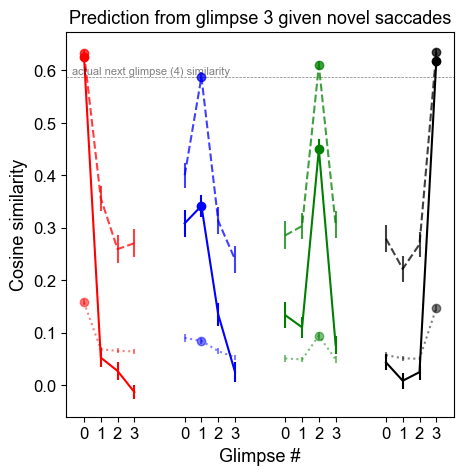

In [19]:
if glimpse_loss:
    # Define a helper function to plot error bars
    def plot_error_bars(x_offset, color, label, cos_sim_data, alpha=1.0, marker=None, fmt='-', index=0):
        mean_vals = np.mean(cos_sim_data, axis=0)
        sem_vals = np.std(cos_sim_data, axis=0) / np.sqrt(n_scenes)
        x_vals = x_offset + np.arange(n_glimpses)
        plt.errorbar(x_vals, mean_vals, yerr=sem_vals*1.96, color=color, alpha=alpha, label=label, fmt=fmt)
        if marker:
            plt.plot(x_vals[index], mean_vals[index], marker, color=color, alpha=alpha)

    # Plot cosine similarities across scenes
    fig = plt.figure(figsize=(5, 5))
    for i, color in enumerate(['r', 'b', 'g', 'k']):
        x_offset = i * (n_glimpses + 2)
        plot_error_bars(x_offset, color, None if i>0 else 'Actual glimpses', cos_sims[:, i, :, 2], alpha=0.75, marker='o', index=i, fmt='--')
        plot_error_bars(x_offset, color, None if i>0 else 'Randomly-sampled glimpses', cos_sims[:, i, :, 1], alpha=1, marker='o', index=i)
        plot_error_bars(x_offset, color, None if i>0 else 'Shuffled-embedding inputs', cos_sims[:, i, :, 0], alpha=0.5, fmt=':', marker='o', index=i)

    plt.axhline(cos_sims_actual.mean(), color='k', linestyle='--', linewidth=0.5, alpha=0.5) if saccade_type == 'natural' else None
    plt.text(4, cos_sims_actual.mean() + 0.005, 'actual next glimpse (4) similarity', color='k', fontsize=8, alpha=0.5, ha='center') if saccade_type == 'natural' else None

    plt.xticks(
        np.concatenate([np.arange(n_glimpses) + i * (n_glimpses + 2) for i in range(4)]),
        np.tile(np.arange(n_glimpses), 4),
        fontsize=12
    )
    plt.ylabel('Cosine similarity', fontsize=13)
    plt.yticks(fontsize=12)
    plt.title('Prediction from glimpse 3 given novel saccades', fontsize=13)
    # plt.legend()
    plt.xlabel('Glimpse #', fontsize=13)

    # # Add the inset image
    # path_image = plt.imread(f'figures/path_setup_{saccade_type}.png')
    # imagebox = OffsetImage(path_image, zoom=0.15)
    # ab = AnnotationBbox(imagebox, (0.5, 0.8), frameon=False, xycoords='axes fraction')
    # plt.gca().add_artist(ab)

    fig.savefig(
        f'figures/icl_graph_infer_plot_{net_name}.svg',
        format='svg',
        bbox_inches='tight',
        dpi=300.
    )

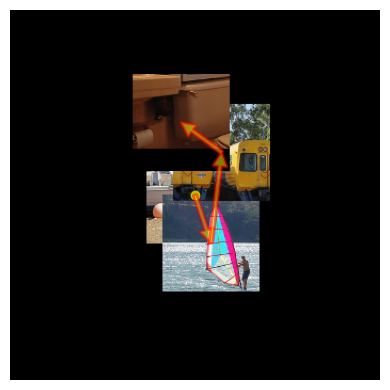

In [20]:
if glimpse_loss:
    # Visualize a novel scene

    sc_id_h = [int(all_traces_img_n[gli_id]) for gli_id in example_scene_glimpse_ids]
    tr_id_h = [int(all_traces_trace_n[gli_id]) for gli_id in example_scene_glimpse_ids]
    gl_id_h = [int(all_traces_glimpse_n[gli_id]) for gli_id in example_scene_glimpse_ids]
    chosen_glimpses_h, _ = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=sc_id_h,trace_ids=tr_id_h,glimpse_ids=gl_id_h, glimpse_ext=glimpse_size, bbv=hyp['dataset']['bbv'], gaze_type=hyp['network']['gaze_type']) if 'e2e' not in net_abbrv else get_coco515_dg3_glimpse_cutouts_and_scene_e2e(scene_ids=sc_id_h,trace_ids=tr_id_h,glimpse_ids=gl_id_h, glimpse_ext=glimpse_size)

    chosen_glimpses_pos = np.zeros((len(example_scene_saccades)+1, 2), dtype=np.int32)
    chosen_glimpses_pos[0, 0] = 128
    chosen_glimpses_pos[0, 1] = 128
    for i, (x, y) in enumerate(example_scene_saccades):
        # print(f"Chosen glimpse {i}: x={x}, y={y}")
        chosen_glimpses_pos[i+1, 0] = chosen_glimpses_pos[i, 0] + x
        chosen_glimpses_pos[i+1, 1] = chosen_glimpses_pos[i, 1] + y

    # Plot the chosen glimpses centered on the corresponding chosen_glimpses_pos in a single 256px+padding image - overlap is fine
    novel_scene_image = np.zeros((256+glimpse_size, 256+glimpse_size, 3), dtype=np.uint8)
    # glimpse_size = chosen_glimpses_h[0].shape[0]
    for i, glimpse in enumerate(chosen_glimpses_h):
        x_pos = chosen_glimpses_pos[i, 0]
        y_pos = chosen_glimpses_pos[i, 1]
        # print(f"Placing glimpse {i} at position: x={x_pos}, y={y_pos}")
        novel_scene_image[y_pos:y_pos+glimpse_size, x_pos:x_pos+glimpse_size, :] = glimpse
    plt.figure(figsize=(4, 4))
    plt.imshow(novel_scene_image)
    plt.axis('off')
    plt.tight_layout()
    # draw saccades sequentially on the scene starter to trace the full path taken
    plt.plot((256+glimpse_size)//2, (256+glimpse_size)//2, 'o', color='y')
    # plt.arrow((256+glimpse_size)//2, (256+glimpse_size)//2, example_scene_saccades[0,0], example_scene_saccades[0,1], head_width=10, head_length=10, fc='r', ec='r')
    # now_here = [(256+glimpse_size)//2+example_scene_saccades[0,0], (256+glimpse_size)//2+example_scene_saccades[0,1]]
    # for saccade_idx in range(1,example_scene_saccades.shape[0]-1):
    #     plt.arrow(now_here[0], now_here[1], example_scene_saccades[saccade_idx,0], example_scene_saccades[saccade_idx,1], head_width=10, head_length=10, fc='r', ec='r')
    #     now_here[0] += example_scene_saccades[saccade_idx,0]
    #     now_here[1] += example_scene_saccades[saccade_idx,1]
    now_here = [(256+glimpse_size)//2, (256+glimpse_size)//2]
    for saccade_idx in range(0,example_scene_saccades.shape[0]-1):
        saccade = example_scene_saccades[saccade_idx, :]
        next_here = [now_here[0] + saccade[0], now_here[1] + saccade[1]]
        plt.annotate(
            '',
            xy=next_here,
            xytext=now_here,
            arrowprops=dict(
                arrowstyle='Simple, tail_width=0.25, head_width=1, head_length=1',
                edgecolor='r',
                facecolor='yellow',
                lw=2,
                shrinkA=0,
                shrinkB=0,
                alpha=0.5,
            )
        )
        now_here = next_here

    plt.savefig(
        f'figures/icl_graph_infer_example_scene_{net_name}.svg',
        format='svg',
        bbox_inches='tight',
        dpi=300.
    )

### Absolute position decoding from all GPN layers

In [21]:
# Decode absolute positions of the glimpses from lstm reps

if perform_position_decoding == 1:

    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import KFold, cross_val_predict
    from sklearn.metrics import r2_score

    stacked_lstm_reps = {}
    for key in lstm_reps.keys():
        stacked_lstm_reps[key] = np.vstack(lstm_reps[key])

    stacked_fix_coords = np.vstack(fix_coords_all)

    R2_scores = {}

    for key in stacked_lstm_reps.keys():
        
        n_samples, n_glimpses, n_features = stacked_lstm_reps[key].shape
        _, _, n_targets = stacked_fix_coords[:,1:,:].shape

        X_h = stacked_lstm_reps[key].reshape(-1, n_features)
        Y_h = stacked_fix_coords[:,1:,:].reshape(-1, n_targets)

        glimpse_ids = np.tile(np.arange(n_glimpses), n_samples)

        # Set up a cross-validation splitter.
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        lr = LinearRegression()
        # Use cross_val_predict to obtain out-of-fold predictions for all flattened samples.
        y_pred = cross_val_predict(lr, X_h, Y_h, cv=kf)

        # Compute per-gaze R^2 scores.
        R2_scores[key] = {}
        for gaze in np.unique(glimpse_ids):
            mask = (glimpse_ids == gaze)
            r2 = r2_score(Y_h[mask], y_pred[mask])
            R2_scores[key][gaze] = r2
            # print(f"{key} - Glimpse {gaze}: R^2 = {r2:.3f}")

    # Save the R2 scores
    with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'wb') as f:
        pickle.dump(R2_scores, f)
    print(f'Saved R2 scores to saved_actvs/{net_name}_R2_scores.pkl')

elif perform_position_decoding == 2:
    # Load the R2 scores
    with open(f'saved_actvs/{net_name}_R2_scores.pkl', 'rb') as f:
        R2_scores = pickle.load(f)
    print(f'Loaded R2 scores from saved_actvs/{net_name}_R2_scores.pkl')


In [22]:
# Plot the R2 scores for each glimpse for each layer key in a single plot (use line plots)

if perform_position_decoding:

    fig, axs = plt.subplots(1, 1, figsize=(4, 4))
    for i, (key, r2_scores) in enumerate(R2_scores.items()):
        axs.plot(list(r2_scores.keys()), list(r2_scores.values()), marker='o', label=key)
        title_str = net_abbrv.split('-Sim')[0] if 'SimCLR' in net_abbrv else net_abbrv
        axs.set_title(f'Predicting next glimpse location - {title_str}', fontsize=13)
        axs.set_xlabel('Glimpse #', fontsize=13)
        axs.set_ylabel(r'R$^2$ Score (5-fold CV)', fontsize=13)
        axs.set_xticks(list(r2_scores.keys()))
        axs.set_xticklabels(list(r2_scores.keys()), fontsize=12)
        axs.set_yticks(np.round(np.linspace(0, 1, 6), 2))
        axs.set_yticklabels(np.round(axs.get_yticks(), 2), fontsize=10)
        # axs.grid(True)
        axs.legend(fontsize=12)
        plt.tight_layout()

    fig.savefig(
        f'figures/position_decoding_{net_name}.svg',
        format='svg',
        bbox_inches='tight',
        dpi=300.
    )

### Repr: NSD alignment

#### About the training details of the networks used:

- GPN - COCO
- RN50 - IN1k
- DINOv2 - LVD-142M (contains IN1k/22k, ADE, etc. - see Tabel 15 in https://arxiv.org/pdf/2304.07193#page=29.10)
- DINO-WebSSL - MetaCLIP webdata (1B+)
- MAE - IN1k - MetaCLIP webdata (1B+)
- MAE-WebSSL - MetaCLIP webdata
- iJEPA - IN1k/22k
- CLIP - 400M image-text pairs (would contain scenes)
- SigLIP2 - WebLI 10B image-text pairs

In [23]:
# Plotting correlations of ventral stream RDMs with ALL network RDMs to choose exemplary networks and layers for each class

if extract_all_network_rdm_correlations:

    rdm_files = sorted(glob.glob('rdms/*test_515_RDMs.pkl'))
    network_names_all = [f.split('/')[-1].split('_test')[0] for f in rdm_files]

    # Get ventral stream RDMs
    data_NSD = load_pickle('rdms/streams_all_neural_rdms_correlation_special515.pkl')
    ventral_RDMs = np.vstack([data_NSD[subj]['ventral'] for subj in data_NSD])
    n_subjects = len(ventral_RDMs)
    noise_ceiling = compute_noise_ceiling(ventral_RDMs)

    # Extract nnames for the best layers per network

    net_corr, net_names, net_layer_names = compute_network_correlations_all(ventral_RDMs, rdm_files)
    # find axes
    select_layers = ~np.isnan(net_corr.mean(axis=0))
    net_names = [x for x, m in zip(net_names, select_layers) if m]
    net_layer_names = [x for x, m in zip(net_layer_names, select_layers) if m]
    net_corr = net_corr[:,select_layers]
    # net_corr /= noise_ceiling

    best_layer_names = []
    net_corr_best_layers = []
    net_names_all = []
    net_layers_compared_all = []
    for net_name_h in set(net_names):
        net_name_ids = [i for i in range(len(net_names)) if net_names[i] == net_name_h]
        net_layer_best_id = np.argmax(net_corr[:,net_name_ids].mean(axis=0))
        net_names_all.append(net_name_h)
        best_layer_names.append(net_layer_names[net_name_ids[net_layer_best_id]])
        net_corr_best_layers.append(net_corr[:,net_name_ids[net_layer_best_id]])
        net_layers_compared_all.append(len(net_name_ids))

    with open('saved_actvs/best_network_layers.pkl', 'wb') as f:
        pickle.dump({
            'net_names': net_names_all,
            'best_layer_names': best_layer_names,
            'net_corr_best_layers': np.array(net_corr_best_layers),
            'noise_ceiling': noise_ceiling,
            'net_layers_compared_all': net_layers_compared_all,
        }, f)

    print('Saved best network layers to saved_actvs/best_network_layers.pkl')

else:

    with open('saved_actvs/best_network_layers.pkl', 'rb') as f:
        best_layers_data = pickle.load(f)
    net_names_all = best_layers_data['net_names']
    best_layer_names = best_layers_data['best_layer_names']
    net_corr_best_layers = best_layers_data['net_corr_best_layers']
    noise_ceiling = best_layers_data['noise_ceiling']
    net_layers_compared_all = best_layers_data['net_layers_compared_all']

    print('Loaded best network layers from saved_actvs/best_network_layers.pkl')

net_corr_best_layers = np.array(net_corr_best_layers).T

Loaded best network layers from saved_actvs/best_network_layers.pkl


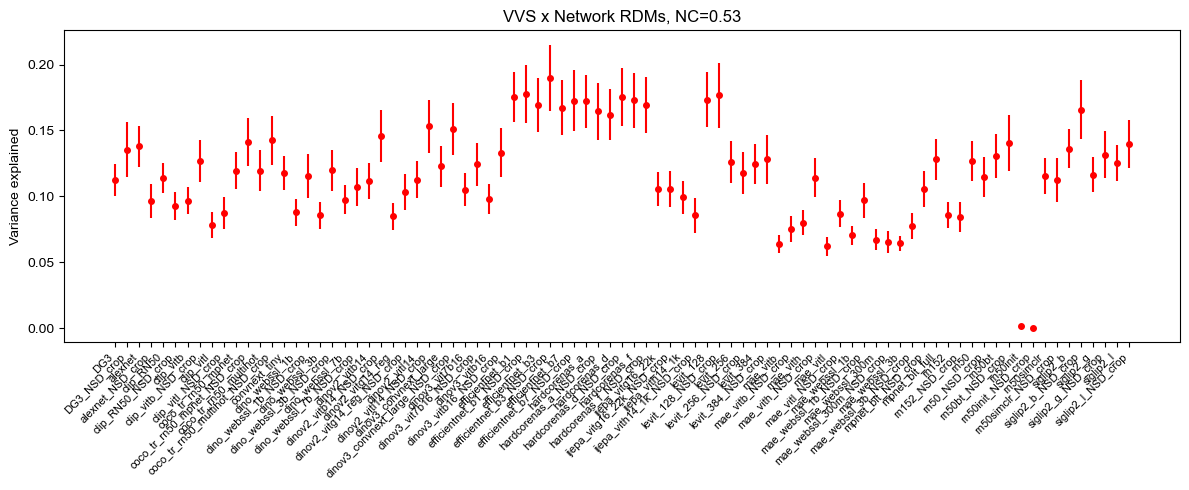

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

sorting_indices = np.argsort(net_names_all)

n_subjects = net_corr_best_layers.shape[0]
ax.errorbar(np.arange(len(net_names_all)), net_corr_best_layers[:,sorting_indices].mean(axis=0),
                yerr=1.96*net_corr_best_layers[:,sorting_indices].std(axis=0)/np.sqrt(n_subjects),
                fmt='ro', markersize=4)

xtick_positions = np.arange(len(net_names_all))
xtick_labels = np.array(net_names_all)[sorting_indices]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Variance explained')
ax.set_title(f'VVS x Network RDMs, NC={noise_ceiling:.2f}')
plt.tight_layout()
plt.show()

In [25]:
[[np.array(net_names_all)[sorting_indices][n], np.array(best_layer_names)[sorting_indices][n], net_corr_best_layers[:,sorting_indices].mean(axis=0)[n]] for n in range(len(net_names_all))]

[['DG3',
  'features.features.1.features.denseblock4.denselayer3.norm1',
  0.11248808001017199],
 ['DG3_NSD_crop',
  'features.features.1.features.denseblock3.denselayer28.norm2',
  0.13549810811295204],
 ['alexnet', 'classifier.1', 0.13790681606154082],
 ['alexnet_NSD_crop', 'classifier.1', 0.09667971314941655],
 ['clip_RN50', 'visual.layer4.1.bn1', 0.1140327241699992],
 ['clip_RN50_NSD_crop', 'visual.layer4.1.conv2', 0.0925256091680897],
 ['clip_vitb', 'visual.ln_post', 0.09682460208470278],
 ['clip_vitb_NSD_crop',
  'visual.transformer.resblocks.8.ln_2',
  0.12700993248307635],
 ['clip_vitl', 'visual.transformer.resblocks.11.attn', 0.07842836582343286],
 ['clip_vitl_NSD_crop',
  'visual.transformer.resblocks.11.attn',
  0.08726314139170888],
 ['coco_tr_rn50_mpnet', 'layer4.1.bn2', 0.11951418434389725],
 ['coco_tr_rn50_mpnet_NSD_crop', 'fc.5', 0.14138082530894086],
 ['coco_tr_rn50_multihot', 'fc.5', 0.11949441425810697],
 ['coco_tr_rn50_multihot_NSD_crop', 'fc.5', 0.14255634733078687

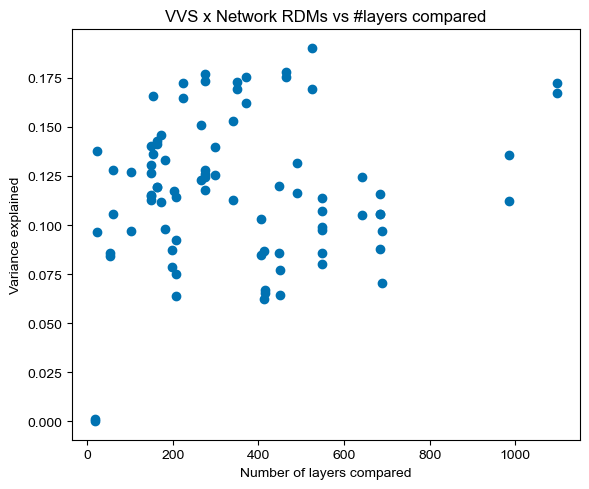

In [26]:
# Plot net_layers_compared_all vs net_corr_best

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(net_layers_compared_all, net_corr_best_layers.mean(axis=0))
# for i, txt in enumerate(np.array(net_names_all)):
#     ax.annotate(txt, (net_layers_compared_all[i], net_corr_best_layers.mean(axis=0)[i]), fontsize=8, alpha=0.7)
ax.set_xlabel('Number of layers compared')
ax.set_ylabel('Variance explained')
ax.set_title('VVS x Network RDMs vs #layers compared')
plt.tight_layout()

Loaded GPN RDMs from rdms/gpn_rdms_gpn_lstm_n_1024_tm_3_t_6_recurrence_1_loc_1_bbv6_gaze_dg3_indp_0.1_rnndp_0.1_gcpc_1_semc_0_scc_0_locmse_0_insplit_0_reg_1_tr_train_515_gdva_NSD_lr_0.0001_num_1.pkl


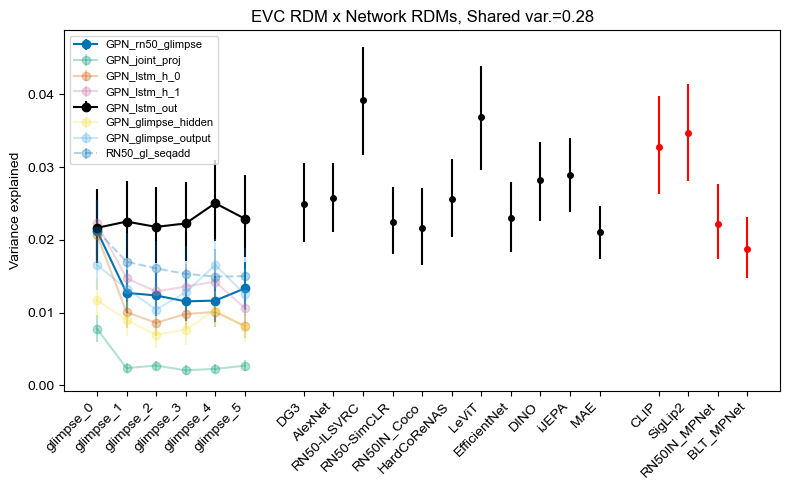

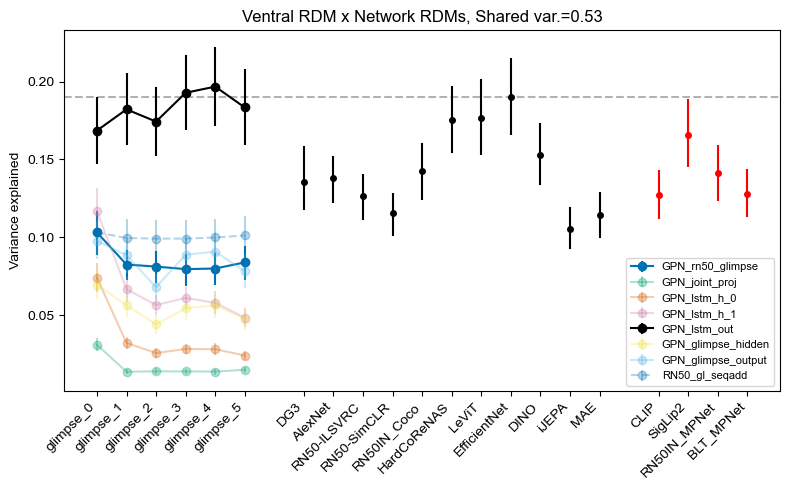

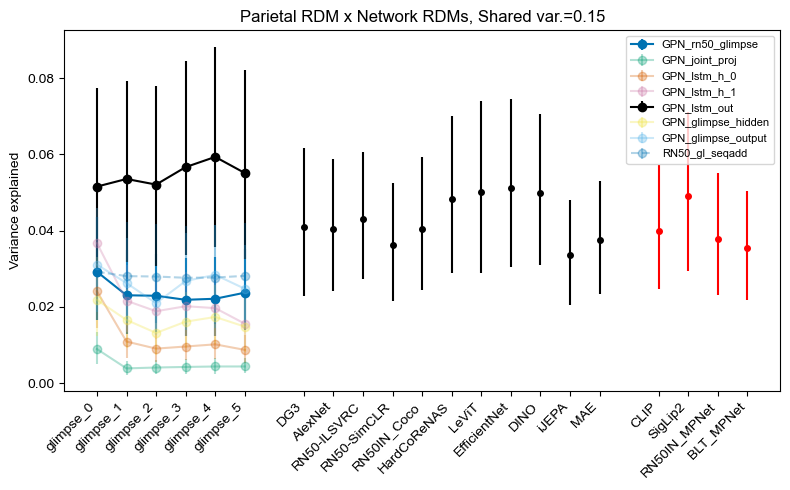

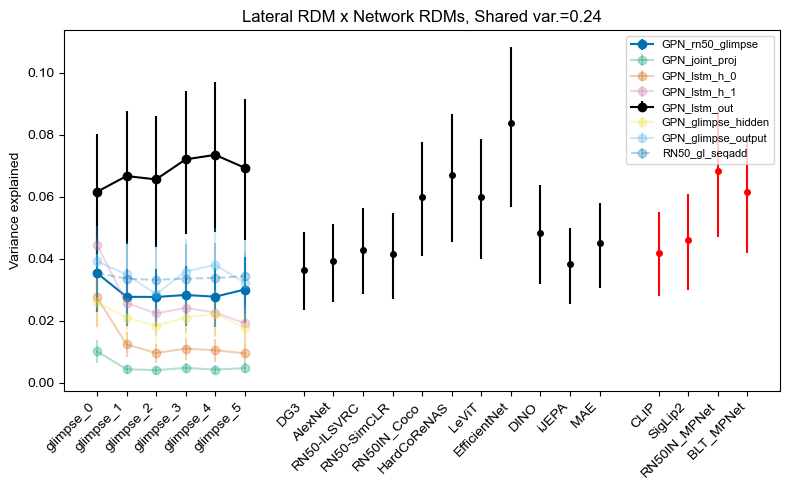

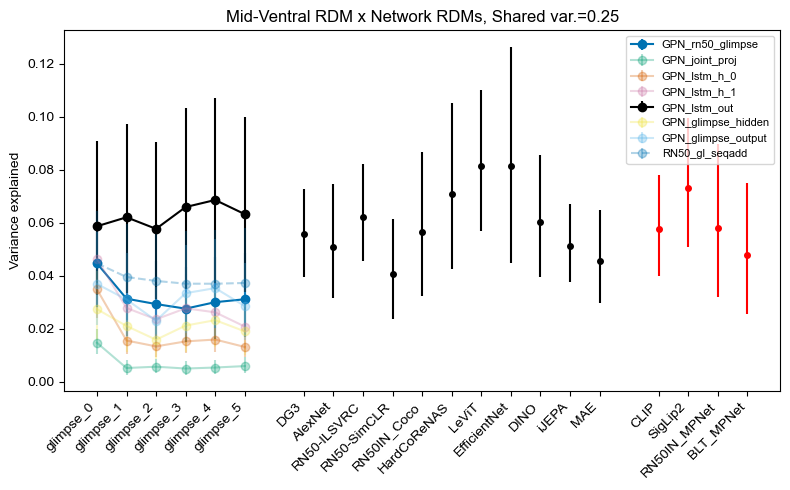

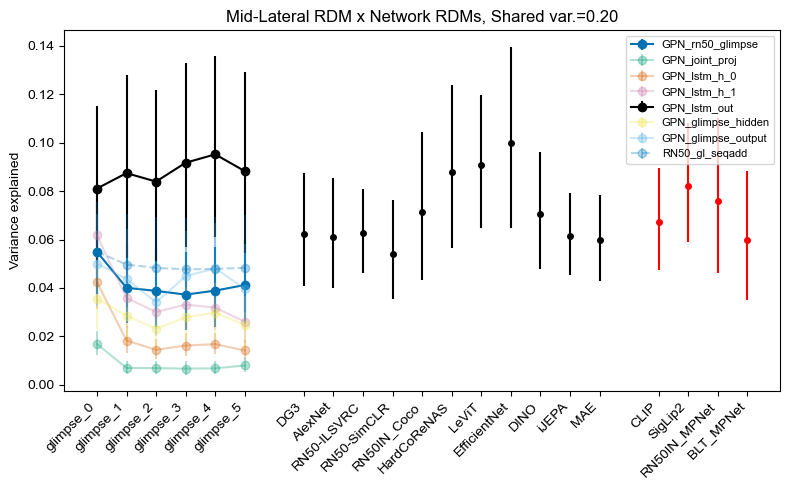

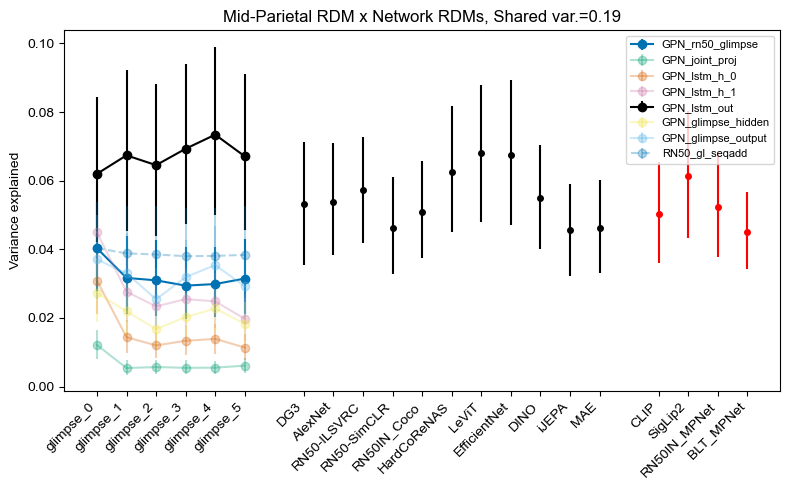

In [27]:
# Plotting correlations b/w streams ROIs, GPN RDMs, and exemplary network RDMs

# Load NSD neural RDMs and create a dictionary for the three ROIs.
data_NSD = load_pickle('rdms/streams_all_neural_rdms_correlation_special515.pkl')
EVC_RDMs = np.vstack([data_NSD[subj]['early'] for subj in data_NSD])
midventral_RDMs = np.vstack([data_NSD[subj]['midventral'] for subj in data_NSD])
midlateral_RDMs = np.vstack([data_NSD[subj]['midlateral'] for subj in data_NSD])
midparietal_RDMs = np.vstack([data_NSD[subj]['midparietal'] for subj in data_NSD])
ventral_RDMs = np.vstack([data_NSD[subj]['ventral'] for subj in data_NSD])
lateral_RDMs = np.vstack([data_NSD[subj]['lateral'] for subj in data_NSD])
parietal_RDMs = np.vstack([data_NSD[subj]['parietal'] for subj in data_NSD])
neural_rdms_dict = {'EVC': EVC_RDMs, 'Ventral': ventral_RDMs, 'Parietal': parietal_RDMs, 'Lateral': lateral_RDMs, 'Mid-Ventral': midventral_RDMs, 'Mid-Lateral': midlateral_RDMs, 'Mid-Parietal': midparietal_RDMs}

# Compute noise ceilings for each ROI.
noise_ceilings = {roi: compute_noise_ceiling(rdms) for roi, rdms in neural_rdms_dict.items()}

# Load the neural RDMs for the models
network_rdms = {'V':{}, 'VL':{}}
with open('rdms/DG3_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    dg3_RDM = pickle.load(f)['features.features.1.features.denseblock3.denselayer28.norm2']
network_rdms['V']['DG3'] = dg3_RDM

with open('rdms/alexnet_test_515_RDMs.pkl', 'rb') as f:
    alexnet_RDM = pickle.load(f)['classifier.1']
network_rdms['V']['AlexNet'] = alexnet_RDM
with open('rdms/rn50_test_515_RDMs.pkl', 'rb') as f:
    rn50_RDM = pickle.load(f)['layer4.1.bn2']
network_rdms['V']['RN50-ILSVRC'] = rn50_RDM
with open('rdms/rn50simclr_test_515_RDMs.pkl', 'rb') as f:
    rn50_simclr_RDM = pickle.load(f)['avgpool']
network_rdms['V']['RN50-SimCLR'] = rn50_simclr_RDM
with open('rdms/coco_tr_rn50_multihot_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    coco_tr_cat_rn50_RDM = pickle.load(f)['fc.5']
network_rdms['V']['RN50IN_Coco'] = coco_tr_cat_rn50_RDM
with open('rdms/hardcorenas_d_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    hardcorenas_RDM = pickle.load(f)['blocks.5.1.se.conv_reduce']
network_rdms['V']['HardCoReNAS'] = hardcorenas_RDM
with open('rdms/levit_128_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    levit_RDM = pickle.load(f)['stages.2.blocks.0.attn.qkv.linear']
network_rdms['V']['LeViT'] = levit_RDM
with open('rdms/efficientnet_b3_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    effnet_RDM = pickle.load(f)['features.6.4.block.2.fc1']
network_rdms['V']['EfficientNet'] = effnet_RDM
with open('rdms/dinov2_vitl14_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    dino_RDM = pickle.load(f)['blocks.23.norm2']
network_rdms['V']['DINO'] = dino_RDM
with open('rdms/ijepa_vitg16_22k_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    ijepa_RDM = pickle.load(f)['encoder.layer.31.intermediate.dense']
network_rdms['V']['iJEPA'] = ijepa_RDM
with open('rdms/mae_vith_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    mae_RDM = pickle.load(f)['encoder.layer.15.intermediate.dense']
network_rdms['V']['MAE'] = mae_RDM

with open('rdms/clip_vitb_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    clip_RDM = pickle.load(f)['visual.transformer.resblocks.8.ln_2']
network_rdms['VL']['CLIP'] = clip_RDM
with open('rdms/siglip2_b_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    siglip2_RDM = pickle.load(f)['vision_model.encoder.layers.7.layer_norm2']
network_rdms['VL']['SigLip2'] = siglip2_RDM
with open('rdms/coco_tr_rn50_mpnet_NSD_crop_test_515_RDMs.pkl', 'rb') as f:
    coco_tr_rn50_RDM = pickle.load(f)['fc.5']
network_rdms['VL']['RN50IN_MPNet'] = coco_tr_rn50_RDM
with open('rdms/mpnet_blt_full_test_515_RDMs.pkl', 'rb') as f:
    mpnet_blt_rdm = pickle.load(f)['layernorm_layer_9_time_0']
network_rdms['VL']['BLT_MPNet'] = mpnet_blt_rdm
model_corr, model_names = compute_network_correlations(ventral_RDMs, network_rdms)

# Get GP RDMs
if extract_gpn_rdms:
    averaging = False  # should we avg GP RDMs across traces?
    dataloader = get_test_515_loader(hyp) if 'e2e' not in net_abbrv else get_test_515_loader_e2e(hyp)
    gpn_rdms = extract_GPN_RDMs(dataloader, net, hyp, averaging=averaging) if 'e2e' not in net_abbrv else extract_GPN_RDMs_e2e(dataloader, net, hyp, averaging=averaging)
    # gpn_rdms_avg = extract_GPN_RDMs(dataloader, net, hyp, averaging=True)
    # Save the GP RDMs
    with open(f'rdms/gpn_rdms_{net_name}.pkl', 'wb') as f:
        pickle.dump(gpn_rdms, f)
        # pickle.dump(gpn_rdms_avg, f)
    print(f'Saved GPN RDMs to rdms/gpn_rdms_{net_name}.pkl')
else:
    # Load the GP RDMs
    with open(f'rdms/gpn_rdms_{net_name}.pkl', 'rb') as f:
        gpn_rdms = pickle.load(f)
        # gpn_rdms_avg = pickle.load(f)
    print(f'Loaded GPN RDMs from rdms/gpn_rdms_{net_name}.pkl')

# ----------------------------
# Loop over each ROI to compute and plot correlations.
# ----------------------------
n_glimpse = 6
select_gpn_layers = ['rn50_glimpse', 'joint_proj']
if timestep_multiplier > 1:
    select_gpn_layers += [f'lstm_h_{i}' for i in range(timestep_multiplier-1)]
select_gpn_layers += ['lstm_out']
if glimpse_loss:
    select_gpn_layers += ['glimpse_hidden', 'glimpse_output'] 
elif semantic_loss:
    select_gpn_layers += ['semantic_hidden', 'semantic_output']
elif scene_loss:
    select_gpn_layers += ['scene_hidden', 'scene_output']
select_gpn_layers += ['RN50_gl_seqadd']

for roi, neural_rdms in neural_rdms_dict.items():
    noise_ceiling = noise_ceilings[roi]
    n_subjects = len(neural_rdms)
    
    fig, ax = plt.subplots(figsize=(8, 5))

    gpn_corr = compute_gpn_correlations(neural_rdms, gpn_rdms, select_gpn_layers, n_glimpse=n_glimpse)
    # gpn_corr = gpn_corr**2 / noise_ceiling**2 # Shared variance explained

    # Plot gp network correlations (one curve per layer across 6 glimpse positions)
    for i, layer in enumerate(select_gpn_layers):
        fmt = 'ko-' if i == len(select_gpn_layers)-4 else ('o-' if i < len(select_gpn_layers)-1 else 'o--')
        mean_h, _, _, err_low, err_high = mean_and_bootstrap_ci(gpn_corr[:, :, i])
        ax.errorbar(np.arange(6), mean_h,
                    yerr=np.stack([err_low, err_high]),
                    fmt=fmt, label=f'GPN_{layer}' if i < len(select_gpn_layers)-1 else f'{layer}', alpha=1 if (i == len(select_gpn_layers)-4 or i==0) else 0.3)

    # For the remaining networks, assign x positions offset to the right.
    pos_networks_v = np.arange(n_glimpse+1, n_glimpse+1+len(network_rdms['V'].keys()))  # positions for vision models
    pos_networks_vl = np.arange(n_glimpse+1+len(network_rdms['V'].keys())+1, n_glimpse+1+len(network_rdms['V'].keys())+1+len(network_rdms['VL'].keys()))  # positions for visuolinguistic models

    # Compute correlations for other (non-gp) network RDMs.
    net_corr, net_names = compute_network_correlations(neural_rdms, network_rdms)
    # net_corr = net_corr**2 / noise_ceiling**2 # Shared variance explained

    # Plot V nets
    mean_h, _, _, err_low, err_high = mean_and_bootstrap_ci(net_corr[:, :len(network_rdms['V'].keys())])
    ax.errorbar(pos_networks_v, mean_h,
                yerr=np.stack([err_low, err_high]),
                fmt='ko', markersize=4)
    # Plot VL nets
    mean_h, _, _, err_low, err_high = mean_and_bootstrap_ci(net_corr[:, len(network_rdms['V'].keys()):])
    ax.errorbar(pos_networks_vl, mean_h,
                yerr=np.stack([err_low, err_high]),
                fmt='ro', markersize=4)
    
    # draw hline with MPNet_BLT mean correlation
    ax.axhline(net_corr.mean(axis=0).max(), color='k', linestyle='--', alpha=0.3) if roi == 'Ventral' else None
    # print(f'{roi}_{net_corr[:, -1].mean():.3f}')
    
    # Set custom x-tick labels (empty strings denote gaps).
    labels = [f'glimpse_{i}' for i in range(n_glimpse)] + [' '] + net_names[:len(network_rdms['V'].keys())] + [' '] + net_names[len(network_rdms['V'].keys()):]
    xtick_positions = [i for i, lab in enumerate(labels) if lab != ' ']
    xtick_labels = [lab for lab in labels if lab != ' ']

    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
    ax.set_ylabel('Variance explained')
    ax.set_title(f'{roi} RDM x Network RDMs, Shared var.={noise_ceiling:.2f}')
    ax.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

    # Save the figure
    # fig.savefig(
    #     f'figures/rdm_correlations_{roi}_gpn_{net_name}_vs_networks.svg',
    #     format='svg',
    #     bbox_inches='tight',
    #     dpi=150.
    # )
    

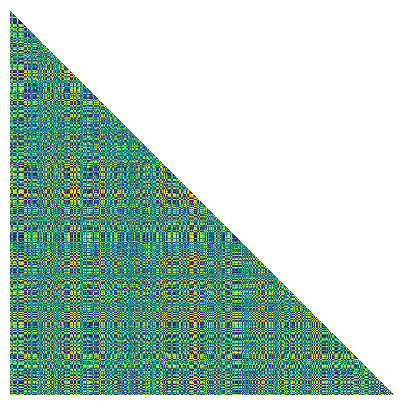

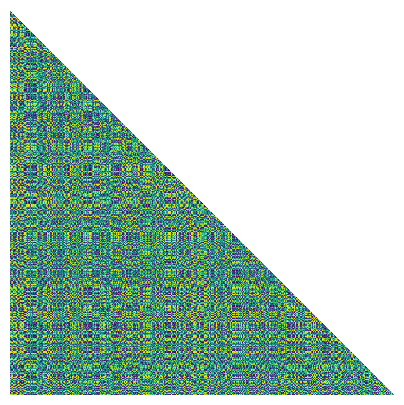

In [28]:
# Visualize RDMs for lstm_out at glimpse 5 and avg subject ventral stream

import seaborn as sns
import scipy

def rank_lower_triangle_only(M):
    M = np.asarray(M, dtype=float)
    n = M.shape[0]
    il, jl = np.tril_indices(n, k=-1)          # lower triangle, no diagonal
    ranks = scipy.stats.rankdata(M[il, jl])     # ranks over lower triangle only
    M_rank = M.copy()
    M_rank[il, jl] = ranks
    return M_rank

# Average ventral stream RDM across subjects
data_NSD = load_pickle('rdms/streams_all_neural_rdms_correlation_special515.pkl')
ventral_RDMs = np.vstack([data_NSD[subj]['ventral'] for subj in data_NSD])
ventral_RDM_avg = scipy.spatial.distance.squareform(ventral_RDMs.mean(axis=0))
# rank-transform LOWER triangle only
ventral_RDM_avg = rank_lower_triangle_only(ventral_RDM_avg)

# Extract lstm_out at glimpse 5
gpn_rdms_lstm_out = gpn_rdms['lstm_out']
gpn_rdms_lstm_out_glimpse5 = scipy.spatial.distance.squareform(gpn_rdms_lstm_out[5, :])
# rank-transform LOWER triangle only
gpn_rdms_lstm_out_glimpse5 = rank_lower_triangle_only(gpn_rdms_lstm_out_glimpse5)

# Common mask (hide upper triangle + diagonal) and color scale
n = ventral_RDM_avg.shape[0]
mask_lower_only = np.triu(np.ones((n, n), dtype=bool), k=0)
vmin, vmax = 1, n * (n - 1) // 2  # rank range

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(ventral_RDM_avg, mask=mask_lower_only, cmap='viridis',
            cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax)
ax.set_xticks([]); ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.show()

#Save the figure
fig.savefig(
    f'figures/rdm_visualization_vvs.svg',
    format='svg',
    bbox_inches='tight',
    dpi=150.
)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(gpn_rdms_lstm_out_glimpse5, mask=mask_lower_only, cmap='viridis',
            cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax)
ax.set_xticks([]); ax.set_yticks([])
ax.set_aspect('equal', 'box')
plt.show()

#Save the figure
fig.savefig(
    f'figures/rdm_visualization_gpn_{net_name}.svg',
    format='svg',
    bbox_inches='tight',
    dpi=150.
)

In [29]:
# Correlation of GPN RDMs with largest Siglip2 RDMs and largest DINO_webssl RDMs

from scipy.stats import pearsonr

with open('rdms/dino_webssl_7b_test_515_RDMs.pkl', 'rb') as f:
    dino_webssl_7b_RDM = pickle.load(f)['layernorm']
with open('rdms/siglip2_l_test_515_RDMs.pkl', 'rb') as f:
    siglip2_l_RDM = pickle.load(f)['vision_model.head']

layers_choose_gpn = ['rn50_glimpse', 'lstm_out']

gpn_nets_corr = np.zeros((len(layers_choose_gpn), 2, gpn_rdms[layers_choose_gpn[0]].shape[0])) # layers x (DINO_webssl, Siglip2) x glimpses
for i, layer in enumerate(layers_choose_gpn):
    for j, other_net_rdm in enumerate([dino_webssl_7b_RDM, siglip2_l_RDM]):
        for k in range(gpn_rdms[layer].shape[0]):
            gpn_nets_corr[i, j, k] = pearsonr(gpn_rdms[layer][k], other_net_rdm)[0]

Corr of DINO_webssl_7b with SigLip2_L: 0.629


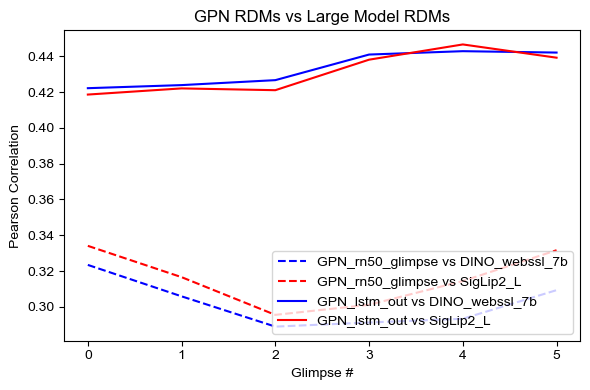

In [30]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
i_markers = ['--', '-']
j_colors = ['b', 'r']
labels = ['DINO_webssl_7b', 'SigLip2_L']
for i in range(len(layers_choose_gpn)):
    for j in range(2):
        ax.plot(np.arange(gpn_nets_corr.shape[2]), gpn_nets_corr[i, j, :], j_colors[j]+i_markers[i], label=f'GPN_{layers_choose_gpn[i]} vs {labels[j]}')
ax.set_xlabel('Glimpse #')
ax.set_ylabel('Pearson Correlation')
ax.set_title('GPN RDMs vs Large Model RDMs')
ax.legend(loc='lower right')
plt.tight_layout()

print(f'Corr of {labels[0]} with {labels[1]}: {pearsonr(dino_webssl_7b_RDM, siglip2_l_RDM)[0]:.3f}')

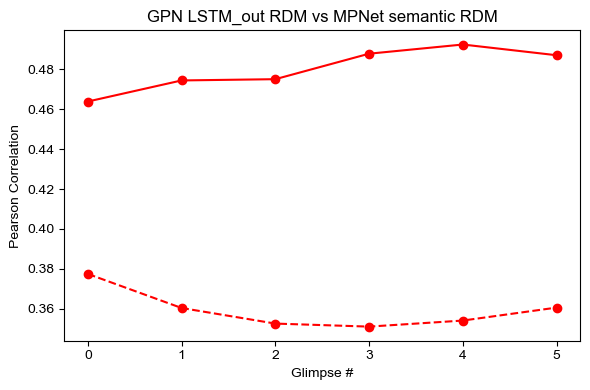

In [31]:
# Correlation with semantic embeddings RDM (MPNet)

mpnet_rdm = gpn_rdms['semantic_embed']
gpn_rdms_lstm = gpn_rdms['lstm_out']
gpn_rdms_input = gpn_rdms['rn50_glimpse']
gpn_semantic_corr = np.zeros((gpn_rdms_lstm.shape[0],2))
for i in range(gpn_rdms_lstm.shape[0]):
    gpn_semantic_corr[i,0] = pearsonr(gpn_rdms_lstm[i], mpnet_rdm)[0] 
    gpn_semantic_corr[i,1] = pearsonr(gpn_rdms_input[i], mpnet_rdm)[0]
# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(len(gpn_semantic_corr)), gpn_semantic_corr[:,0], 'ro-')
ax.plot(np.arange(len(gpn_semantic_corr)), gpn_semantic_corr[:,1], 'ro--')
ax.set_xlabel('Glimpse #')
ax.set_ylabel('Pearson Correlation')
ax.set_title('GPN LSTM_out RDM vs MPNet semantic RDM')
plt.tight_layout()

### Comparing the RDM rows of models

In [32]:
from scipy.spatial.distance import squareform

avg_ventral_rdm = squareform(ventral_RDMs.mean(axis=0))[:,:-1]
rn50_glimpse_rdm = squareform(gpn_rdms['rn50_glimpse'][0])[:,:-1]
lstm_out_rdm = squareform(gpn_rdms['lstm_out'][0])[:,:-1]

vvc_corrs_rn50_lstm_out = np.zeros((avg_ventral_rdm.shape[0], 2)) # scenes x (rn50_glimpse, lstm_out)
for i in range(avg_ventral_rdm.shape[0]):
    idxs_choose = np.delete(np.arange(avg_ventral_rdm.shape[0]), i)
    avg_ventral_rdm[i,:] = squareform(ventral_RDMs.mean(axis=0))[i,idxs_choose]
    rn50_glimpse_rdm[i,:] = squareform(gpn_rdms['rn50_glimpse'][0])[i,idxs_choose]
    lstm_out_rdm[i,:] = squareform(gpn_rdms['lstm_out'][0])[i,idxs_choose]
    vvc_corrs_rn50_lstm_out[i, 0] = pearsonr(avg_ventral_rdm[i,:], rn50_glimpse_rdm[i,:])[0]
    vvc_corrs_rn50_lstm_out[i, 1] = pearsonr(avg_ventral_rdm[i,:], lstm_out_rdm[i,:])[0]

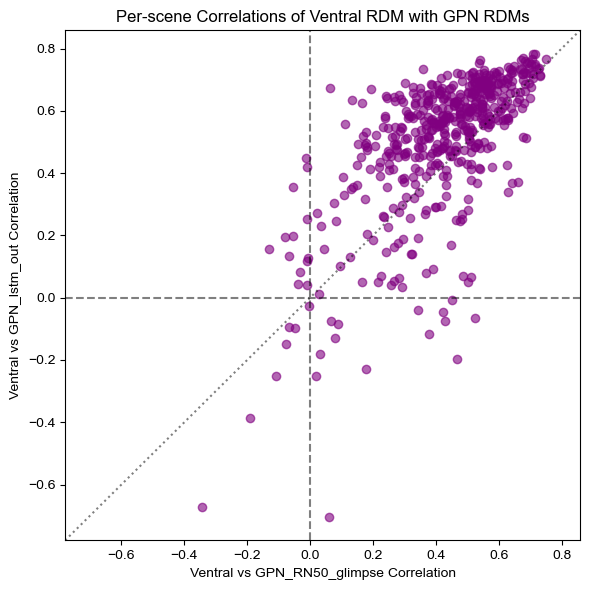

In [33]:
# Scatterplot the correlations; also plot axes going through (0,0 )
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(vvc_corrs_rn50_lstm_out[:,0], vvc_corrs_rn50_lstm_out[:,1], color='purple', alpha=0.6)
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k:', alpha=0.5)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Ventral vs GPN_RN50_glimpse Correlation')
ax.set_ylabel('Ventral vs GPN_lstm_out Correlation')
ax.set_title('Per-scene Correlations of Ventral RDM with GPN RDMs')
plt.tight_layout()

In [34]:
# Get the 3 best correlating rows, 3 with near zero correlation, and 3 worst correlating rows, per GPN RDM

best_worst_idxs = {}
for i, layer in enumerate(['rn50_glimpse', 'lstm_out']):
    sorted_indices = np.argsort(vvc_corrs_rn50_lstm_out[:,i])
    best_worst_idxs[layer] = {
        'best': sorted_indices[-5:][::-1],  # Top 3 indices with highest correlation
        'neutral': sorted_indices[np.abs(vvc_corrs_rn50_lstm_out[sorted_indices,i]).argsort()[:5]],  # 3 indices with correlation closest to zero
        'worst': sorted_indices[:5]  # Bottom 3 indices with lowest correlation
    }

# Get the 5 scenes that maximise the difference in correlation between the two GPN RDMs to the ventral RDM; 5 where lstm_out is higher, 5 where rn50 is

diff_corr = vvc_corrs_rn50_lstm_out[:,1] - vvc_corrs_rn50_lstm_out[:,0]
sorted_diff_indices = np.argsort(diff_corr)
best_worst_diff_idxs = {
    'lstm_better': sorted_diff_indices[-5:][::-1],  # Top 5 indices where lstm_out correlation is higher
    'rn50_better': sorted_diff_indices[:5]  # Top 5 indices where rn50_glimpse correlation is higher   
}

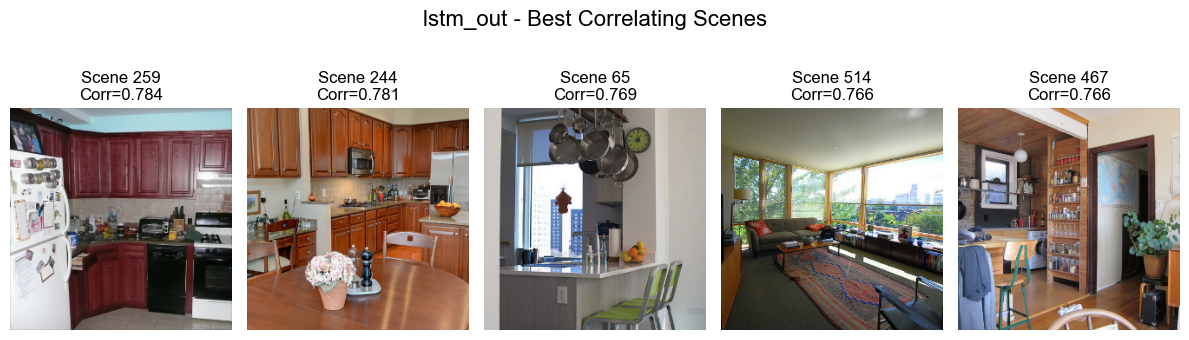

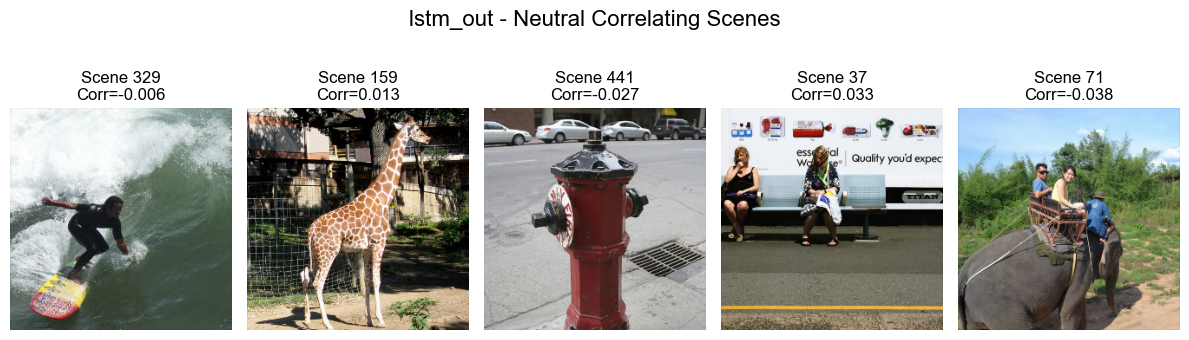

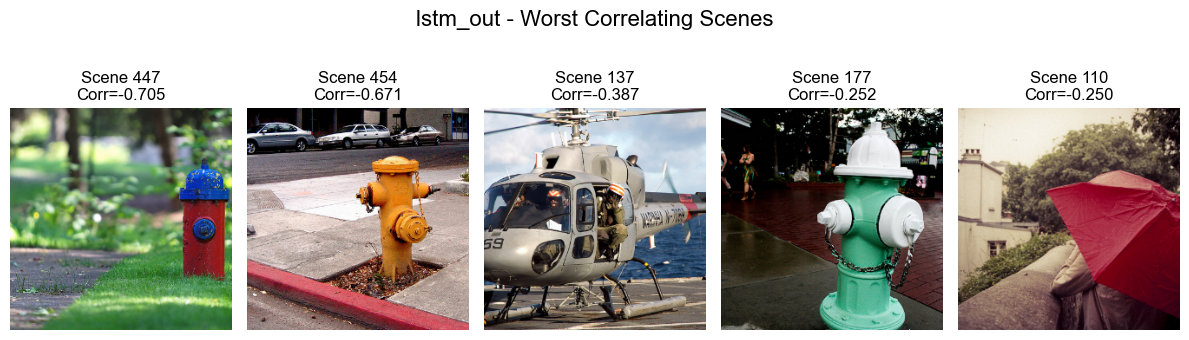

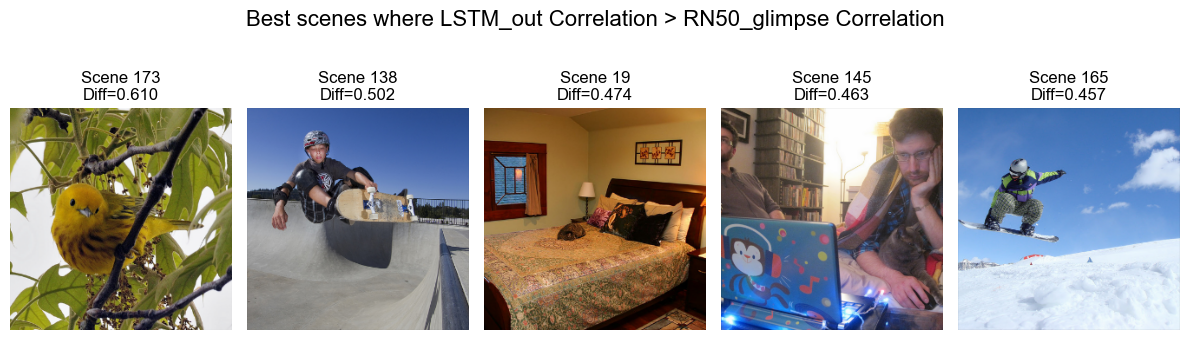

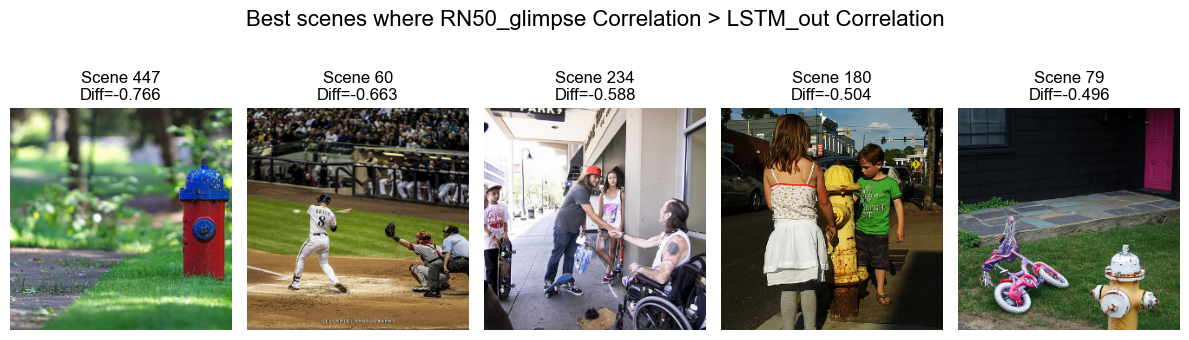

In [35]:
# Plot the scenes corresponding to these indices, with the correlation value in the title

for layer, idx_dict in best_worst_idxs.items():
    if layer == 'lstm_out':
        for category, indices in idx_dict.items():
            fig, axs = plt.subplots(1, 5, figsize=(12, 4))
            for ax, idx in zip(axs, indices):
                scene_id = idx
                trace_id = 0
                glimpse_id = 0
                _, img = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=[scene_id], trace_ids=[trace_id], glimpse_ids=[glimpse_id], glimpse_ext=glimpse_size, bbv=hyp['dataset']['bbv'], gaze_type=hyp['network']['gaze_type'])
                ax.imshow(img)
                ax.set_title(f'Scene {scene_id}\nCorr={vvc_corrs_rn50_lstm_out[idx, ["rn50_glimpse", "lstm_out"].index(layer)]:.3f}')
                ax.axis('off')
            plt.suptitle(f'{layer} - {category.capitalize()} Correlating Scenes', fontsize=16)
            plt.tight_layout()
            plt.show()

# Plot the scenes corresponding to the best_worst_diff_idxs indices

fig, axs = plt.subplots(1, 5, figsize=(12, 4))
for ax, idx in zip(axs, best_worst_diff_idxs['lstm_better']):
    scene_id = idx
    trace_id = 0
    glimpse_id = 0
    _, img = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=[scene_id], trace_ids=[trace_id], glimpse_ids=[glimpse_id], glimpse_ext=glimpse_size, bbv=hyp['dataset']['bbv'], gaze_type=hyp['network']['gaze_type'])
    ax.imshow(img)
    ax.set_title(f'Scene {scene_id}\nDiff={diff_corr[idx]:.3f}')
    ax.axis('off')
plt.suptitle(f'Best scenes where LSTM_out Correlation > RN50_glimpse Correlation', fontsize=16)
plt.tight_layout()

fig, axs = plt.subplots(1, 5, figsize=(12, 4))
for ax, idx in zip(axs, best_worst_diff_idxs['rn50_better']):
    scene_id = idx
    trace_id = 0
    glimpse_id = 0
    _, img = get_coco515_dg3_glimpse_cutouts_and_scene(scene_ids=[scene_id], trace_ids=[trace_id], glimpse_ids=[glimpse_id], glimpse_ext=glimpse_size, bbv=hyp['dataset']['bbv'], gaze_type=hyp['network']['gaze_type'])
    ax.imshow(img)
    ax.set_title(f'Scene {scene_id}\nDiff={diff_corr[idx]:.3f}')
    ax.axis('off')
plt.suptitle(f'Best scenes where RN50_glimpse Correlation > LSTM_out Correlation', fontsize=16)
plt.tight_layout()



### OTF: from image to DG3 fixation extraction to RN50v1 features to GPN actvs

In [ ]:
otf_extraction = False

if otf_extraction: # rn50-v1
    
    f = h5py.File('datasets/coco-test-515.h5', "r")
    dataset_images_h = f['images'][()]

    from analysis_helpers.otf_extractor import OnTheFlyExtractor

    batch_size_otf = 128
    otf_process = OnTheFlyExtractor(device="mps",dg3_device="mps",rn50_mb=batch_size_otf,dg3_mb=batch_size_otf)

    fix_actvs_h_otf, next_abs_otf, next_rel_otf, _ = otf_process(dataset_images_h)

    with open('dummy.pkl', 'wb') as f:
        pickle.dump((fix_actvs_h_otf, next_abs_otf, next_rel_otf), f)

    activations_otf, outputs_otf = net(torch.Tensor(fix_actvs_h_otf[:,:-1,:]).to(hyp['optimizer']['device']), torch.Tensor(next_rel_otf).to(hyp['optimizer']['device']))

    rdm_gpn_h_0 = pdist(activations_otf['lstm_out'][:,0,:].cpu().detach().numpy(), metric='correlation')
    rdm_gpn_org = gpn_rdms['lstm_out'][0,:]
    corr_gpn_h_ventral = np.array([pearsonr(rdm_gpn_h_0, ventral_RDMs[i])[0] for i in range(ventral_RDMs.shape[0])])
    corr_gpn_org_ventral = np.array([pearsonr(rdm_gpn_org, ventral_RDMs[i])[0] for i in range(ventral_RDMs.shape[0])])

    print(corr_gpn_h_ventral, corr_gpn_org_ventral)